# Autoregressive Models

## Imports

In [1]:
import sys
sys.path.insert(0, '../src/')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from datetime import date
import geopandas as gpd
from IPython.display import display, HTML
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from utils import load_pkl, generate_times
import seaborn as sns; sns.set()
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from metrics import *

from preprocessing import normalize

import tqdm as tqdm
from tqdm.autonotebook import tqdm
tqdm.pandas()

# Imports classes
from Baseline import *
from Regressor import *
from utils import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Loading Data

### Contour Iris

In [2]:
contour_iris = gpd.read_file(
    '../datasets/iris/iris.shp')

convert_to_int = ['dep', 'insee_com', 'iris', 'code_iris']
for col in convert_to_int:
    contour_iris[col] = contour_iris[col].astype(int)

contour_iris = contour_iris[['code_iris', 'geometry', 'dep']]
contour_iris.head();

### Stations and Dates

In [3]:
station_data = pd.read_csv("../datasets/station_to_iris.csv")
station_data.describe();

In [4]:
stations_mode = load_pkl("../datasets/stations_mode.pkl")
subway_stations = [k for k, v in stations_mode.items() if v == 3]
print("Number of Subway stations: {}".format(len(subway_stations)))

Number of Subway stations: 303


Subways stations with less than $80000$ validations per $3$ month. Note that this is before we normalize the data. In the article, they removed $3$ subways stations, assuming that it was closed for renovation work. We printed below the $4$ stations with smaller number of validations.

In [5]:
station_data[(station_data['id'].isin(subway_stations)) & (station_data['validations_count'] < 80000)];

In [6]:
dates = pd.date_range(start="2015-10-01", end="2015-12-31").date

### Discretized Matrix

In [7]:
matrix_6h = np.load("../datasets/6h_matrix.npy")
matrix_2h = np.load("../datasets/2h_matrix.npy")
matrix_15m = np.load("../datasets/15m_matrix.npy")

## Data Analysis and Preprocessing

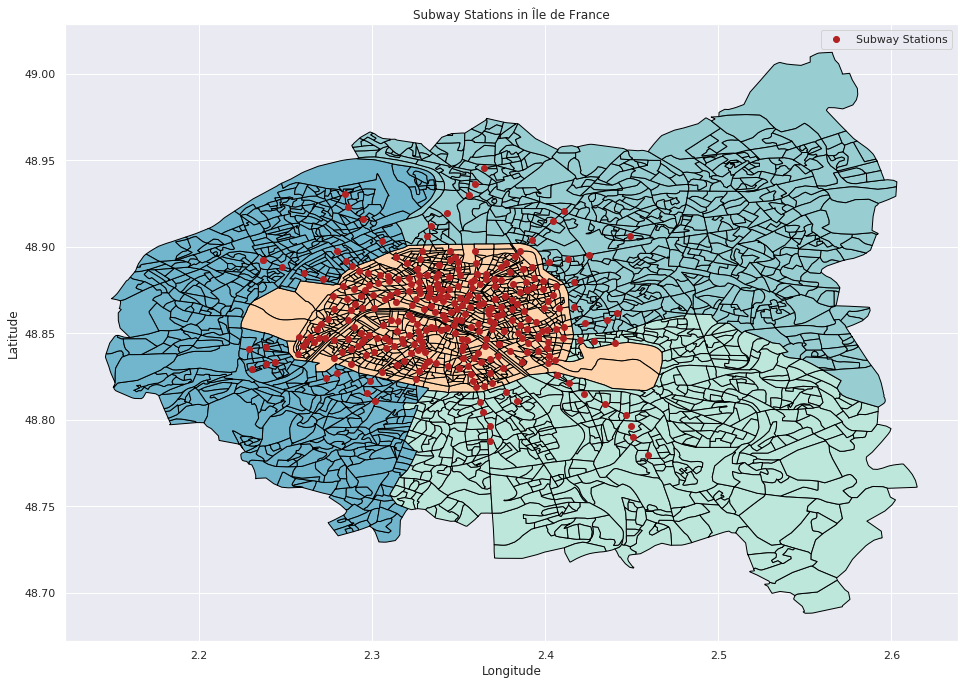

In [8]:
f, ax = plt.subplots(1, figsize=(16, 12))
ax = contour_iris[contour_iris['dep'].isin([75, 92, 93, 94])].plot(
    ax=ax, edgecolor='black', column='dep', cmap='icefire_r')
ax.scatter(station_data[station_data['id'].isin(subway_stations)]['x'],
           station_data[station_data['id'].isin(subway_stations)]['y'], color='firebrick', label='Subway Stations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Subway Stations in Île de France')
ax.legend()

plt.show();

### Min Max Normalization

Below we apply ``Min Max Normalization`` to data, with a scale range of $[0, 1]$.

In [9]:
data_matrix_6h = pd.Panel(normalize(matrix_6h), 
                         items=dates, 
                         major_axis=subway_stations, 
                         minor_axis=generate_times("6h")
                        )

data_matrix_2h = pd.Panel(normalize(matrix_2h), 
                         items=dates, 
                         major_axis=subway_stations, 
                         minor_axis=generate_times("2h")
                        )

data_matrix_15m_complete = pd.Panel(matrix_15m, 
                                    items=dates, 
                                    major_axis=subway_stations, 
                                    minor_axis=generate_times("15min")
                                   )

Delete the first $4$ hours, from $00.00.00$ to $04.00.00$ because it's useless, the number of validations in that range is mostly equal to 0.

In [10]:
del_hours = 4

In [11]:
data_matrix_15m = data_matrix_15m_complete.iloc[:, :, del_hours*4:]

In [12]:
data_matrix_15m.to_frame().head()

2015-10-01  2015-10-02  2015-10-03  2015-10-04  2015-10-05  \
major minor                                                                  
198   04:00:00         0.0         3.0         0.0         0.0         0.0   
      04:15:00         0.0         0.0         0.0         0.0         2.0   
      04:30:00         0.0         1.0         0.0         0.0         0.0   
      04:45:00         1.0         2.0         0.0         2.0         1.0   
      05:00:00         7.0        11.0         6.0        12.0        10.0   

                2015-10-06  2015-10-07  2015-10-08  2015-10-09  2015-10-10  \
major minor                                                                  
198   04:00:00         0.0         0.0         2.0         0.0         0.0   
      04:15:00         0.0         0.0         0.0         0.0         0.0   
      04:30:00         0.0         0.0         0.0         0.0         0.0   
      04:45:00         0.0         1.0         0.0         0.0         0.0   
      05:00:00         6.0         9.0        12.0         9.0        13.0   

                ...  2015-12-22  2015-12-23  2015-12-24  2015-12-25  \
major minor     ...                                                   
198   04:00:00  ...         0.0         0.0         0.0         0.0   
      04:15:00  ...         0.0         0.0         0.0         0.0   
      04:30:00  ...         1.0         1.0         2.0         1.0   
      04:45:00  ...         2.0         0.0         0.0         2.0   
      05:00:00  ...        11.0         9.0         7.0         1.0   

                2015-12-26  2015-12-27  2015-12-28  2015-12-29  2015-12-30  \
major minor                                                                  
198   04:00:00         0.0         0.0         0.0         0.0         0.0   
      04:15:00         0.0         0.0         0.0         0.0         0.0   
      04:30:00         0.0         1.0         0.0         0.0         0.0   
      04:45:00         0.0         0.0         0.0         0.0         0.0   
      05:00:00         5.0        10.0        12.0        10.0        10.0   

                2015-12-31  
major minor                 
198   04:00:00         0.0  
      04:15:00         0.0  
      04:30:00         0.0  
      04:45:00         2.0  
      05:00:00         5.0  

[5 rows x 92 columns]

In [13]:
dmatrix_mean_6h = data_matrix_6h.mean()
dmatrix_mean_2h = data_matrix_2h.mean()
dmatrix_mean_15m = data_matrix_15m.mean()

dtmatrix_mean_6h = dmatrix_mean_6h.transpose()
dtmatrix_mean_2h = dmatrix_mean_2h.transpose()
dtmatrix_mean_15m = dmatrix_mean_15m.transpose()

Again, this is another way to print the stations with a small number of validations.

In [14]:
data_matrix_15m.mean(axis=0)[data_matrix_15m.mean(axis=0).sum(axis=1) < 810];

In [15]:
dmatrix_mean_15m.head()
dtmatrix_mean_15m.head()

2015-10-01  2015-10-02  2015-10-03  2015-10-04  2015-10-05  \
04:00:00    0.112211    0.188119    0.036304    0.392739    0.072607   
04:15:00    0.138614    0.138614    0.029703    0.554455    0.092409   
04:30:00    0.174917    0.148515    0.059406    0.422442    0.075908   
04:45:00    0.376238    0.462046    0.481848    1.072607    0.396040   
05:00:00    2.643564    3.079208    2.458746    3.900990    2.973597   

          2015-10-06  2015-10-07  2015-10-08  2015-10-09  2015-10-10  ...  \
04:00:00    0.095710    0.099010    0.108911    0.108911    0.072607  ...   
04:15:00    0.082508    0.145215    0.072607    0.108911    0.072607  ...   
04:30:00    0.141914    0.141914    0.165017    0.105611    0.102310  ...   
04:45:00    0.501650    0.491749    0.584158    0.590759    0.478548  ...   
05:00:00    3.112211    3.293729    3.468647    3.254125    2.732673  ...   

          2015-12-22  2015-12-23  2015-12-24  2015-12-25  2015-12-26  \
04:00:00    0.066007    0.102310    0.066007    0.029703    0.036304   
04:15:00    0.075908    0.069307    0.056106    0.036304    0.013201   
04:30:00    0.135314    0.135314    0.128713    0.112211    0.099010   
04:45:00    0.468647    0.521452    0.442244    0.339934    0.346535   
05:00:00    2.696370    3.207921    2.920792    1.217822    2.019802   

          2015-12-27  2015-12-28  2015-12-29  2015-12-30  2015-12-31  
04:00:00    0.013201    0.062706    0.089109    0.069307    0.075908  
04:15:00    0.000000    0.085809    0.089109    0.062706    0.102310  
04:30:00    0.079208    0.161716    0.108911    0.099010    0.079208  
04:45:00    0.346535    0.432343    0.419142    0.409241    0.495050  
05:00:00    1.795380    2.805281    2.993399    3.112211    2.798680  

[5 rows x 92 columns]

04:00:00  04:15:00  04:30:00  04:45:00  05:00:00   05:15:00  \
2015-10-01  0.112211  0.138614  0.174917  0.376238  2.643564  19.864686   
2015-10-02  0.188119  0.138614  0.148515  0.462046  3.079208  22.399340   
2015-10-03  0.036304  0.029703  0.059406  0.481848  2.458746  14.254125   
2015-10-04  0.392739  0.554455  0.422442  1.072607  3.900990  15.920792   
2015-10-05  0.072607  0.092409  0.075908  0.396040  2.973597  20.858086   

             05:30:00   05:45:00   06:00:00   06:15:00  ...   21:30:00  \
2015-10-01  31.471947  31.874587  40.541254  48.481848  ...  70.927393   
2015-10-02  34.537954  34.650165  41.858086  50.056106  ...  78.590759   
2015-10-03  20.429043  19.184818  22.465347  24.531353  ...  82.211221   
2015-10-04  19.696370  16.963696  16.247525  17.610561  ...  43.570957   
2015-10-05  32.630363  32.729373  39.689769  52.072607  ...  61.039604   

             21:45:00   22:00:00   22:15:00   22:30:00   22:45:00   23:00:00  \
2015-10-01  66.881188  65.399340  60.584158  60.755776  64.207921  75.128713   
2015-10-02  73.495050  70.907591  65.983498  66.211221  62.917492  66.330033   
2015-10-03  77.181518  73.755776  72.805281  74.570957  76.264026  83.947195   
2015-10-04  43.818482  41.745875  37.462046  36.722772  37.283828  52.759076   
2015-10-05  52.346535  53.125413  46.059406  45.498350  41.036304  41.254125   

             23:15:00   23:30:00   23:45:00  
2015-10-01  64.590759  52.138614  43.818482  
2015-10-02  63.188119  57.755776  54.673267  
2015-10-03  80.049505  76.587459  72.772277  
2015-10-04  37.158416  31.211221  25.254125  
2015-10-05  35.336634  28.003300  22.801980  

[5 rows x 80 columns]

### With Outliers

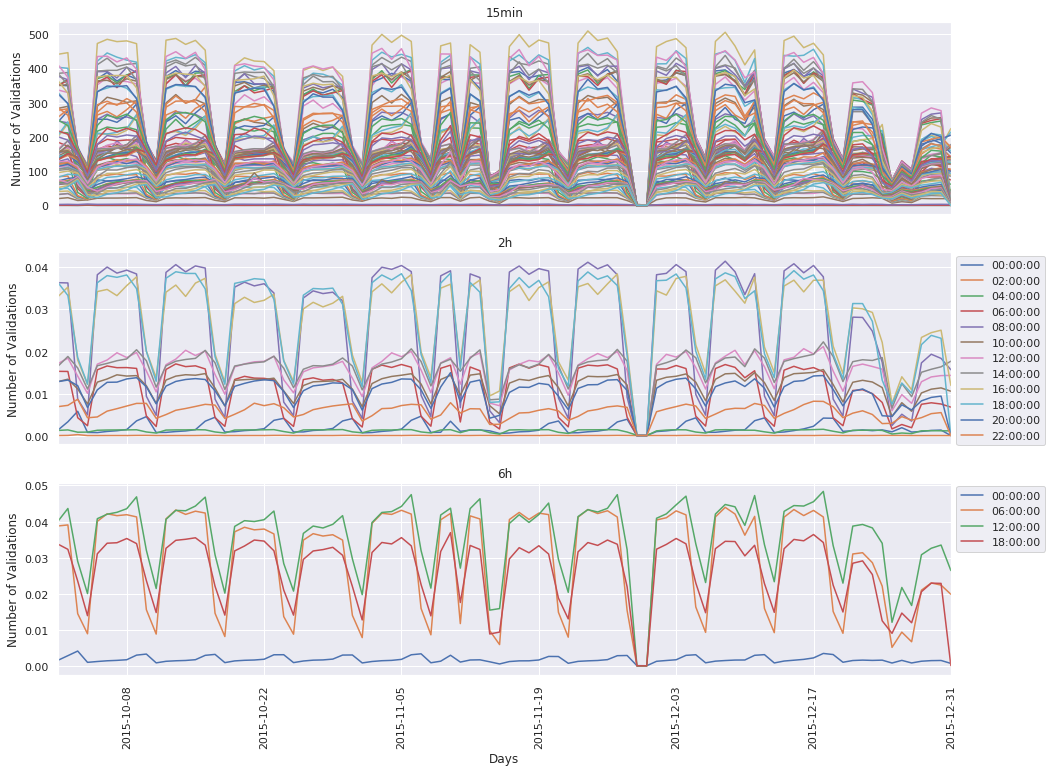

In [16]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = dtmatrix_mean_15m.plot(ax=ax[0], legend=False)
ax1.set_xticklabels([])
ax1.set_ylabel('Number of Validations')
ax1.set_title('15min')

ax2 = dtmatrix_mean_2h.plot(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Number of Validations')
ax2.set_title('2h')
ax2.legend(bbox_to_anchor=(1., 1.01))

ax3 = dtmatrix_mean_6h.plot(ax=ax[2])
ax3.set_xlabel('Days')
ax3.set_ylabel('Number of Validations')
ax3.set_title('6h')
ax3.legend(bbox_to_anchor=(1., 1.01))

plt.xticks(rotation=90)
plt.show();

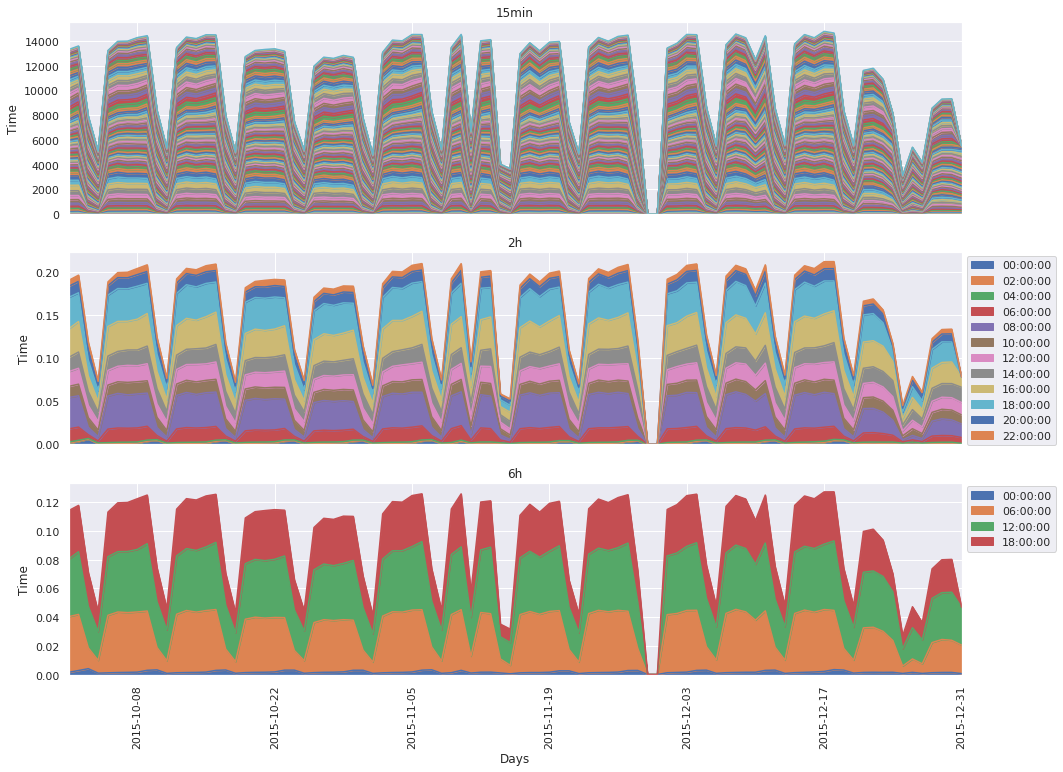

In [17]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = dtmatrix_mean_15m.plot.area(ax=ax[0], legend=False)
ax1.set_xticklabels([])
ax1.set_ylabel('Time')
ax1.set_title('15min')

ax2 = dtmatrix_mean_2h.plot.area(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Time')
ax2.set_title('2h')
ax2.legend(bbox_to_anchor=(1., 1.01))

ax3 = dtmatrix_mean_6h.plot.area(ax=ax[2])
ax3.set_xlabel('Days')
ax3.set_ylabel('Time')
ax3.set_title('6h')
ax3.legend(bbox_to_anchor=(1., 1.01), loc=2)

plt.xticks(rotation=90)
plt.show();

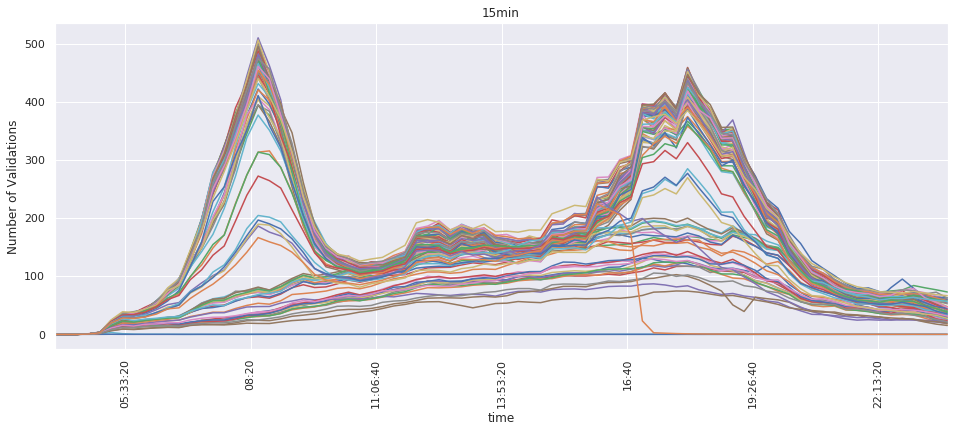

In [18]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0])
dmatrix_mean_15m.plot(ax=ax, legend=False)
plt.ylabel('Number of Validations')
plt.title('15min')

plt.xticks(rotation=90)
plt.show();

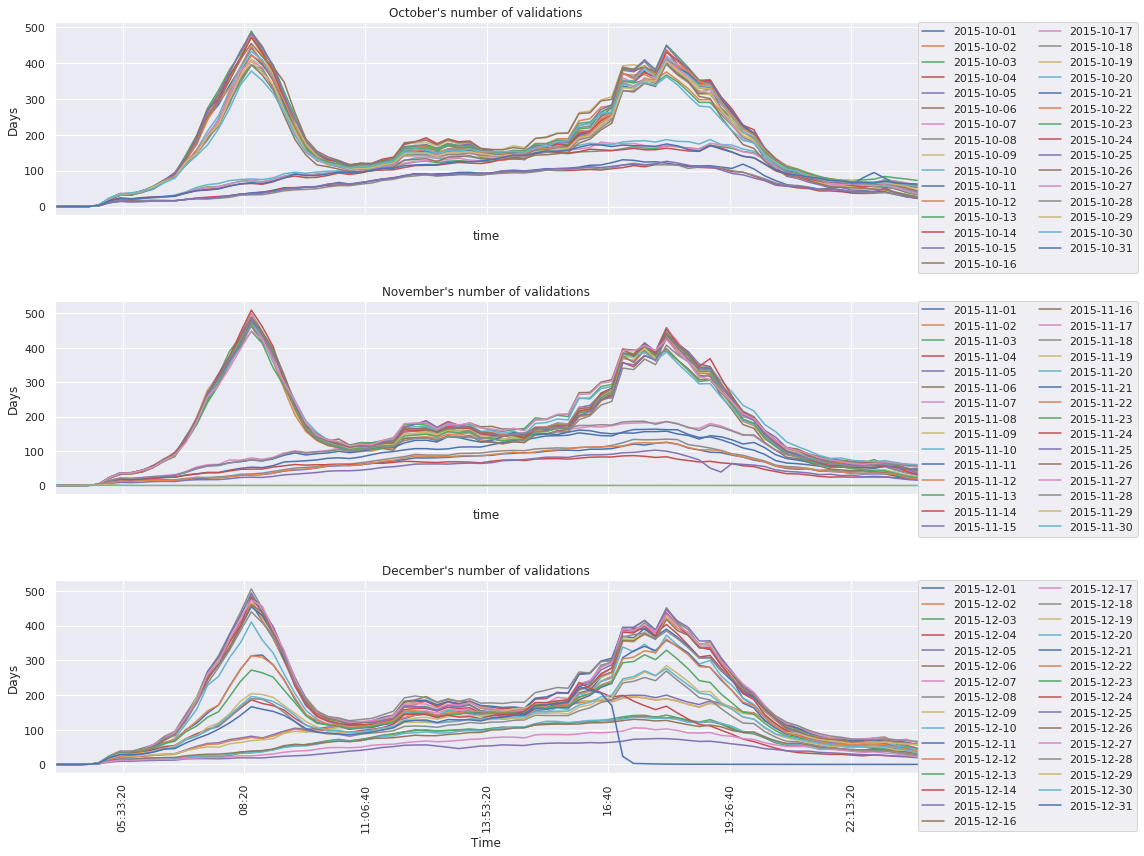

In [19]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = dmatrix_mean_15m.iloc[:, :31].plot(ax=ax[0])
ax1.set_xticklabels([])
ax1.set_ylabel('Days')
ax1.set_title('October\'s number of validations')
ax1.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)


ax2 = dmatrix_mean_15m.iloc[:, 31:61].plot(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Days')
ax2.set_title('November\'s number of validations')
ax2.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

ax3 = dmatrix_mean_15m.iloc[:, 61:].plot(ax=ax[2])
ax3.set_xlabel('Time')
ax3.set_ylabel('Days')
ax3.set_title('December\'s number of validations')
plt.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), loc=2,
           ncol=2, borderaxespad=0.)

plt.xticks(rotation=90)
plt.tight_layout()

plt.show();

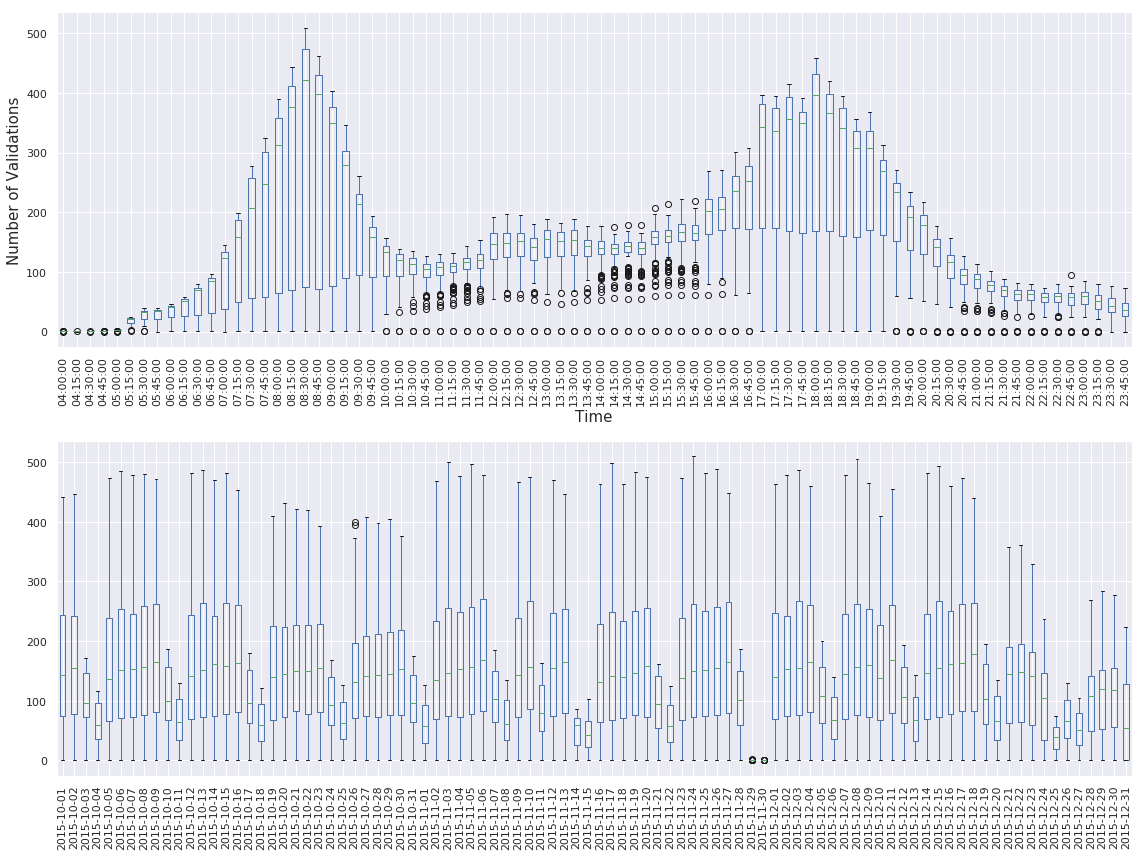

In [20]:
f, ax = plt.subplots(2, figsize=(16, 12))

ax1 = dtmatrix_mean_15m.boxplot(return_type='both', ax=ax[0])
ax[0].set_xlabel("Time", fontsize=15)
ax[0].set_ylabel("Number of Validations", fontsize=15)

for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)

ax2 = dmatrix_mean_15m.boxplot(return_type='both', ax=ax[1])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show();

### Defining useful variables

In [21]:
from __init__ import *

In [22]:
wd_15m = data_matrix_15m.loc[dict_w.values()]
wdm_15m = wd_15m.mean()
wdmt_15m = wdm_15m.transpose()

wd_15mf = data_matrix_15m.loc[dict_wd_final.values()]
wdm_15mf = wd_15mf.mean()
wdmt_15mf = wdm_15mf.transpose()

### Without outliers

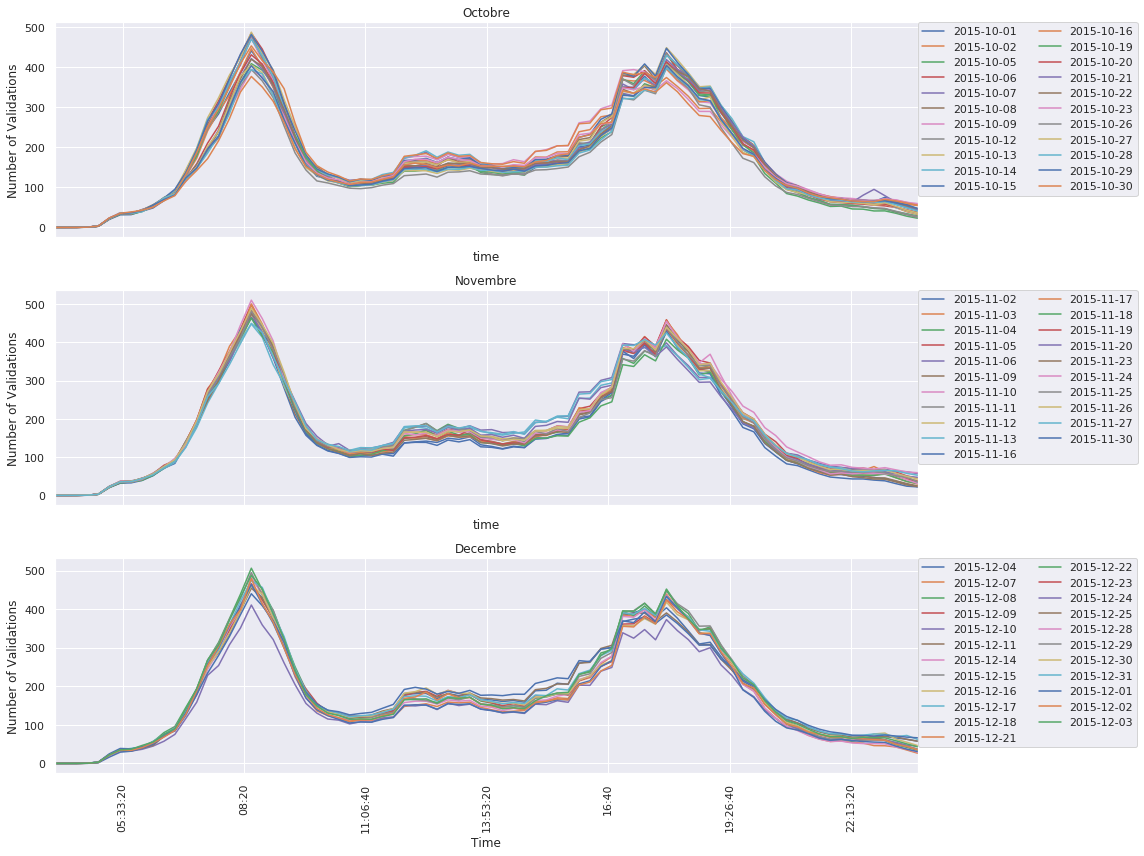

In [23]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = wdm_15m.loc[:, dict_wd_oct.values()].plot(ax=ax[0])
ax1.set_xticklabels([])
ax1.set_ylabel('Number of Validations')
ax1.set_title('Octobre')
ax1.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

ax2 = wdm_15m.loc[:, dict_wd_nov.values()].plot(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Number of Validations')
ax2.set_title('Novembre')
ax2.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

ax3 = wdm_15m.loc[:, dict_wd_dec.values()].plot(ax=ax[2])
ax3.set_xlabel('Time')
ax3.set_ylabel('Number of Validations')
ax3.set_title('Decembre')
plt.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), loc=2,
           ncol=2, borderaxespad=0.)

plt.xticks(rotation=90)
plt.tight_layout()

plt.show();

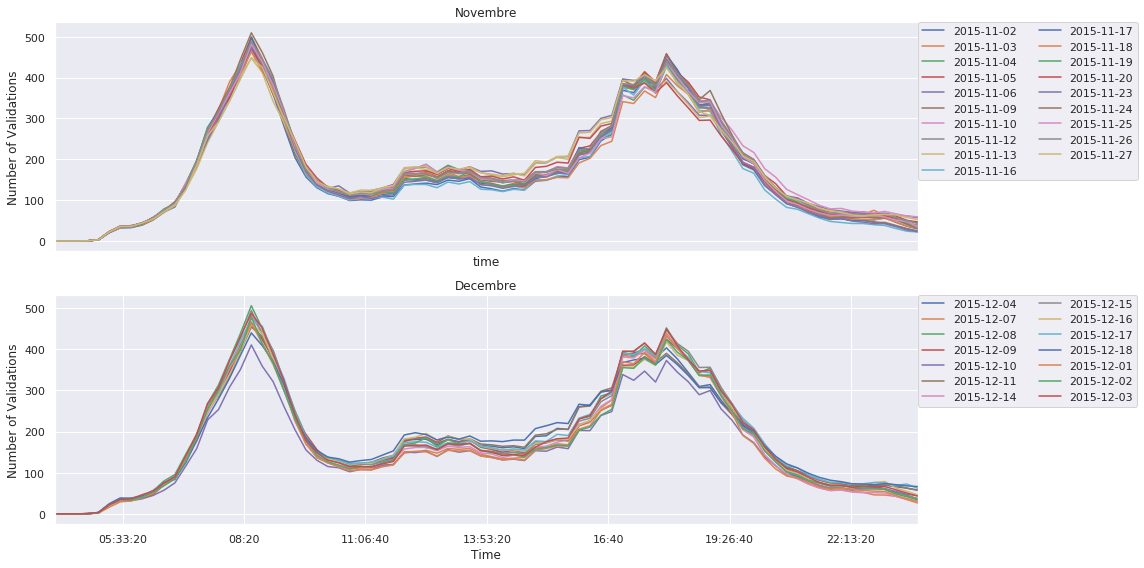

In [24]:
f, ax = plt.subplots(2, figsize=(16, 8))

ax1 = wdm_15mf.loc[:, dict_wd_novf.values()].plot(ax=ax[0])
ax1.set_xticks([])
ax1.set_ylabel('Number of Validations')
ax1.set_title('Novembre')
ax1.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

ax2 = wdm_15mf.loc[:, dict_wd_decf.values()].plot(ax=ax[1])
ax2.set_xlabel('Time')
ax2.set_ylabel('Number of Validations')
ax2.set_title('Decembre')
plt.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), loc=2,
           ncol=2, borderaxespad=0.)
plt.tight_layout()

plt.show();

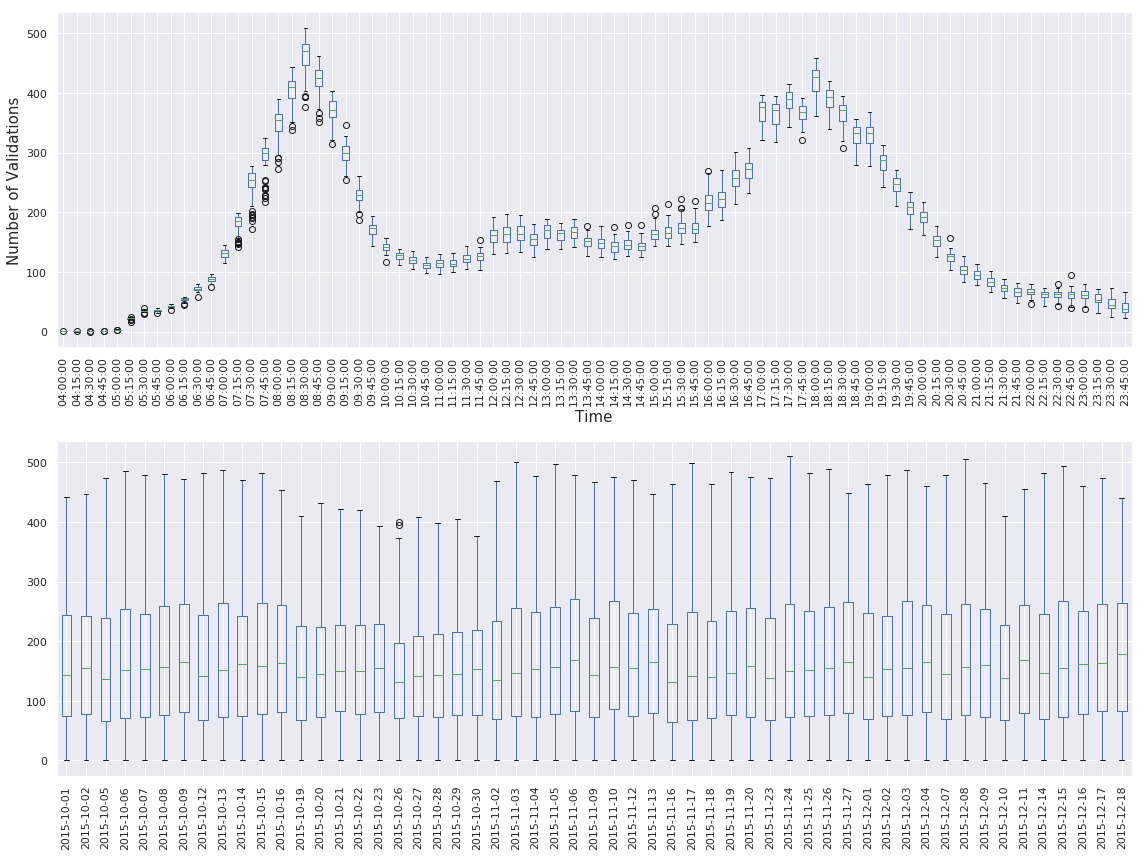

In [25]:
f, ax = plt.subplots(2, figsize=(16, 12))

ax1 = wdmt_15mf.boxplot(return_type='both', ax=ax[0])
ax[0].set_xlabel("Time", fontsize=15)
ax[0].set_ylabel("Number of Validations", fontsize=15)

for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)

ax2 = wdm_15mf.boxplot(return_type='both', ax=ax[1])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show();

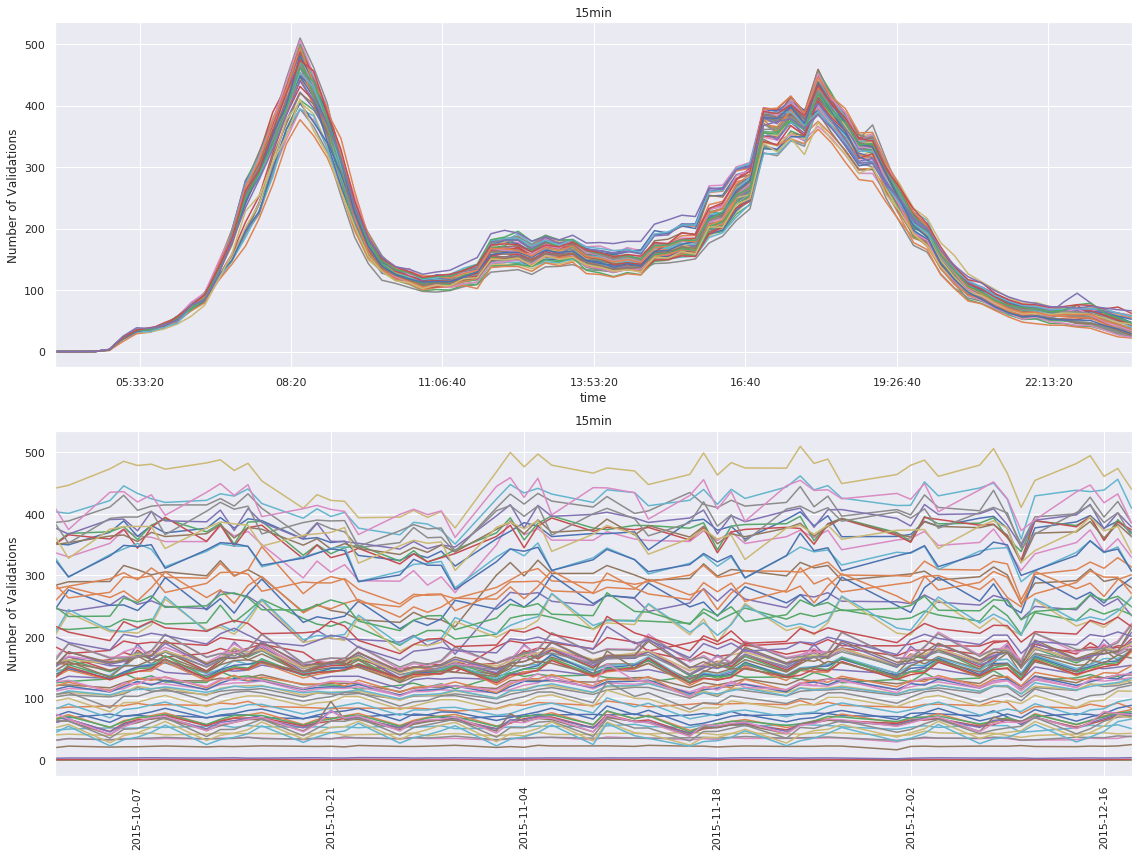

In [26]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 12))

wdm_15mf.plot(ax=ax1, legend=False)
ax1.set_ylabel('Number of Validations'); ax1.set_title('15min')

ax2 = wdmt_15mf.plot(ax=ax2, legend=False)
ax2.set_ylabel('Number of Validations'); ax2.set_title('15min')

plt.xticks(rotation=90)
plt.tight_layout()

plt.show();

### Autocorrelation Plots

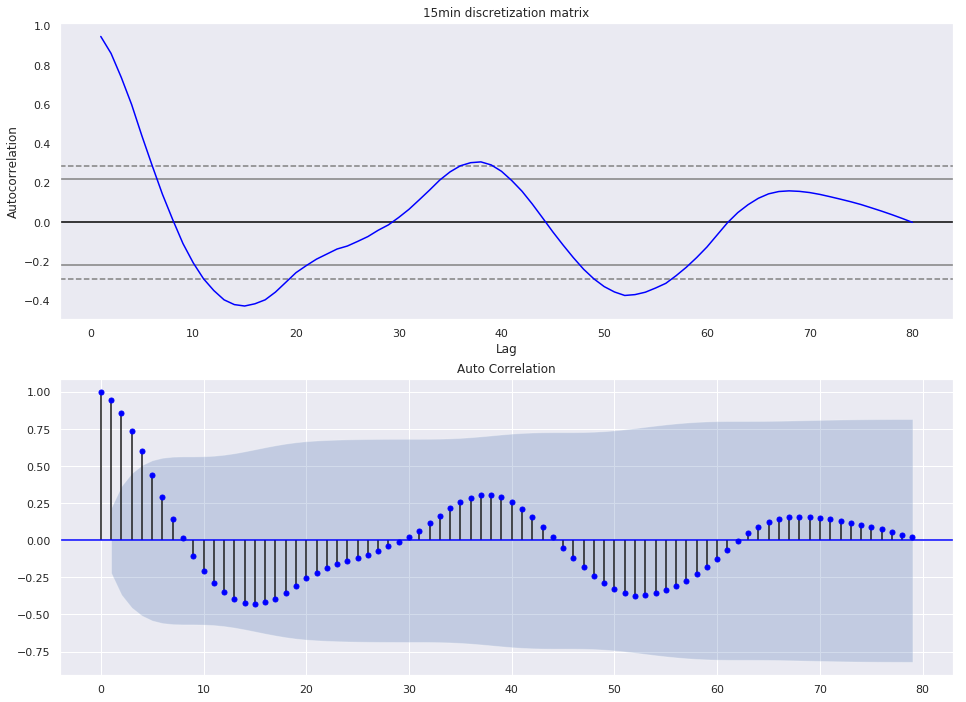

In [27]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 12))

autocorrelation_plot(wdmt_15mf.mean(), ax=ax1, c='blue')
ax1.set_title('15min discretization matrix')

plot_acf(wdmt_15mf.mean(), ax=ax2, c='blue', title='Auto Correlation')

plt.show();

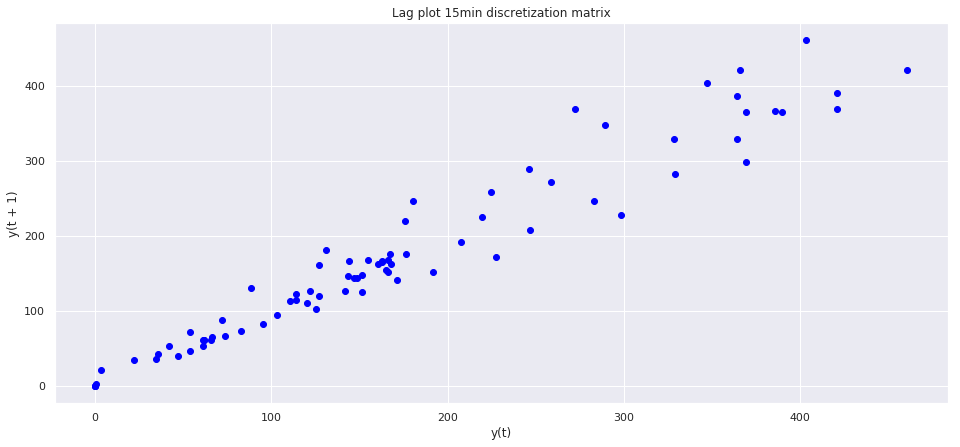

In [28]:
plt.figure(figsize=(16, 7))

lag_plot(wdmt_15mf.mean(), c='blue')
plt.title('Lag plot 15min discretization matrix')

# plot_pacf(wdmt_15mf.mean(), ax=ax[1], c='blue', title='Partial Auto Correlation')

plt.show();

### Splitting Data into Train and Test

In [29]:
# Without outliers with the weekend
dico = dict_w
# Without outliers and without weekend
# dico = dict_wd_final
size = 55

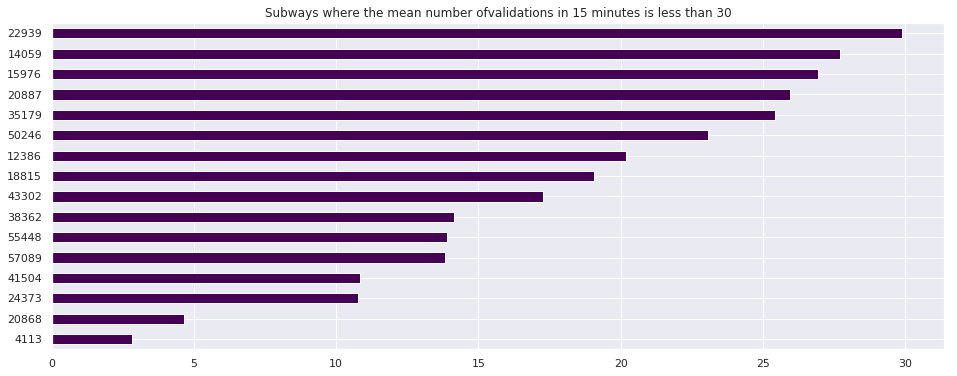

In [30]:
# Define X
X = data_matrix_15m.loc[dico.values()]

# Plot the station's id where the number of validations is less than the
# defined number 'nb_val' below
nb_val = 30
m = X.mean(axis=0).T.mean()
m[m < nb_val].sort_values().plot(kind='barh', grid=True, 
                                 cmap='viridis', 
                                 title="Subways where the mean number of"\
                                 "validations in 15 minutes is less than "\
                                 "{}".format(nb_val),
                                 figsize=(16, 6));

# Delete the stations where the mean number of validations is between 3 and 6
stations_to_del = [4113, 20868]
X.drop(columns=stations_to_del, inplace=True)

In [31]:
Xm = X.mean()
Xmt = Xm.transpose()

try:
    for s in stations_to_del:
        subway_stations.remove(s)
except:
    pass

In [32]:
kw = list(dico.keys())
np.random.shuffle(kw)

vw = [dico[i] for i in kw]

In [85]:
ind_train = vw[:size]
ind_test = vw[size:]
X_train = X[sorted(ind_train)]
X_test = X[sorted(ind_test)]

In [88]:
X_train
X_test

<class 'pandas.core.panel.Panel'>
Dimensions: 55 (items) x 301 (major_axis) x 80 (minor_axis)
Items axis: 2015-10-01 to 2015-12-19
Major_axis axis: 198 to 60982
Minor_axis axis: 04:00:00 to 23:45:00

<class 'pandas.core.panel.Panel'>
Dimensions: 23 (items) x 301 (major_axis) x 80 (minor_axis)
Items axis: 2015-10-04 to 2015-12-20
Major_axis axis: 198 to 60982
Minor_axis axis: 04:00:00 to 23:45:00

In [89]:
X_min_max = X_train.apply(lambda x: (x.min().min(), x.max().max()), axis=(0, 2))

In [90]:
def normalize(X, X_min_max, station_id, a=0, b=1):
    """
    """
    mini, maxi = X_min_max.loc[station_id]
    return (a + ((X.loc[:, station_id] - mini) * (b - a)) / (maxi - mini)).values

def denormalize(X, X_min_max, station_id, a=0, b=1):
    """
    """
    mini, maxi = X_min_max.loc[station_id]
    return (((X.loc[:, station_id] - a) * (maxi - mini)) / (b - a) + mini).values
    

In [91]:
a, b = -1, 1
Xn_train = X_train.apply(lambda x: a + ((x - x.min().min()) * (b - a)) /(x.max().max() - x.min().min()), 
                         axis=(0, 2)).transpose(2, 0, 1)

In [92]:
# Normalize X_test
Xn_test = pd.Panel(np.array(list(map(lambda station_id: normalize(X_test, 
                                                                  X_min_max, 
                                                                  station_id, a=a, b=b), 
                                     X_test.transpose(1, 0, 2)))).transpose(2, 0, 1),
                   items=list(X_test.items),
                   major_axis=subway_stations,
                   minor_axis=generate_times("15min")[(del_hours * 4):])

# Denormalize X_test to verify that it is working
Xdn_test = pd.Panel(np.array(list(map(lambda station_id: denormalize(Xn_test, 
                                                                     X_min_max, 
                                                                     station_id, a=a, b=b), 
                                     Xn_test.transpose(1, 0, 2)))).transpose(2, 0, 1),
                   items=list(Xn_test.items),
                   major_axis=subway_stations,
                   minor_axis=generate_times("15min")[(del_hours * 4):])

## Models

### Baseline

In [93]:
def baseline_plot_results(levels):
    """
    
    """
    
    baseline_scores = []
    baseline_preds = []
    for level in levels:
        b = Baseline(level=level, first_ndays=5)
        b.fit(X_train)
        baseline_preds.append(b.predict(X_test))
        baseline_scores.append(b.score(X_test))
    
    df_baseline_scores = pd.DataFrame(np.array(baseline_scores).T,
                                 index=['R2', 'RMSE', 'MSE', 'MAE', 'MAPE', 'MPE'],
                                 columns=levels)
    display(HTML(df_baseline_scores.to_html()))
    pd.DataFrame(df_baseline_scores.loc['RMSE'].values.repeat(4).reshape(-1, 4).T,
                 columns=levels).plot(figsize=(16, 4), kind='line');
    
    return df_baseline_scores, baseline_preds

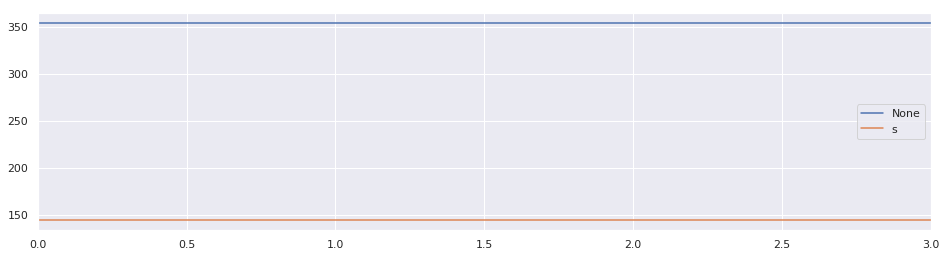

In [94]:
levels = ["None", "s"]
df_baseline_scores, baseline_preds = baseline_plot_results(levels)

In [95]:
from cost_functions import mse, mse_g
from sklearn.linear_model import LinearRegression, Lasso
class myAR(Regressor):
    def __init__(self, order=4, level=None, loss=mse, loss_g=mse_g, max_iter=1000,
                 eps=0.01):
        """ Initialisation des paramètres du perceptron

        :param order: Taille de la fenêtre glissante
        :param loss: fonction de coût
        :param loss_g: gradient de la fonction coût
        :param max_iter: nombre maximum d'itération de la fonction coût
        :param eps: pas du gradient


        """

        self.order = order
        self.level = level
        self.max_iter, self.eps = max_iter, eps
        self.loss, self.loss_g = loss, loss_g
        self.w = np.random.random(self.order)
                      
    
    @Regressor.datax_decorator
    def analytic_fit(self, datax):
        """ Finds the optimal weigths analytically 
        
        :param datax: contient tous les exemples du dataset
        :returns: void
        :rtype: None
        
        """
        
        self.reg = LinearRegression()
        _, self.X, self.y = datax
        A, B = self.X.T.dot(self.X), self.X.T.dot(self.y)
        self.w1 = np.linalg.solve(A, B).ravel()
        self.reg.fit(self.X, self.y)
        self.w = self.reg.coef_.squeeze()
        display(HTML(pd.DataFrame(self.w.reshape(1, -1), index=['Weights'], 
                                  columns=range(1, len(self.w)+1)).to_html()))
        return self

    def minibatch_fit(self, datax):
        """ Mini-Batch gradient descent Learning

        :param datax: contient tous les exemples du dataset
        
        """

        for _ in range(self.max_iter):
            for d in range(datax.shape[0]):
                for t in range(datax.shape[2] - self.order):
                    batchx = datax.iloc[d, :, t:t + self.order].values
                    batchy = datax.iloc[d, :, t + self.order].values
                    self.w -= (self.eps * self.loss_g(batchx, batchy, self.w))
    
    def reshaped(self, y_pred, datax):
        """
        """
        
        if datax.ndim == 3:
            return y_pred.reshape((datax.shape[0] * datax.shape[1], 
                                datax.shape[2] - self.order), 
                                order='F').reshape((datax.shape[0],
                                                   datax.shape[1],
                                                   datax.shape[2] - self.order))
        elif datax.ndim == 2:
            return y_pred.reshape((datax.shape[0], datax.shape[1] - self.order),
                                order='F')
    
    @Regressor.datax_decorator
    def forecast(self, datax, tplus):
        datax, self.X_test, self.y_test = datax
        
        if tplus == 1:
            return self.reshaped(self.reg.predict(self.X_test), datax)
            
        else:
            self.X_test = self.X_test.reshape(datax.shape[-1] - self.order, -1, self.order)
        
            tmp = self.X_test[0]
            y_pred = self.reg.predict(tmp)
            pred = y_pred.copy()

            for x in self.X_test[1:]:
                x[:, -1] = pred.squeeze()
                x[:, -tplus:-1] = tmp[:, -tplus+1:]
                tmp = x.copy()
                pred = self.reg.predict(tmp)
                y_pred = np.vstack((y_pred, pred))

            return self.reshaped(y_pred, datax)

In [96]:
def panelIt(X_pred, X_test, order, subway_stations, del_hours=0):
    """

    """

    wd_testorder_15m = X_test.iloc[:, :, order:]
    minor_axis = generate_times("15min")[(del_hours * 4) + order:]
    
    return pd.Panel(X_pred,
                    items=list(wd_testorder_15m.items),
                    major_axis=subway_stations,
                    minor_axis=minor_axis)

In [97]:
class theAR(Baseline):
    station_id = 0
    def __init__(self, level=None, first_ndays=7, **kwargs):
        """
        
        """
        
        super().__init__(level, first_ndays)
        self.kwargs = kwargs
        
    def fit(self, datax):
        """
        
        """
        
        if self.level is None:
            self.model = myAR(**self.kwargs)
            self.model.analytic_fit(datax)
            
        elif self.level.lower() == "s":
            
            self.models = []            
            
            datax.apply(lambda station: self.models.append(
                myAR(**self.kwargs).analytic_fit(station.T)), 
                        axis=(0, 2))
        
        elif self.level.lower() == "j":
            # TODO
            self.mean = []
            for d in range(self.first_ndays):
                exist_ind = list(set(ddict_days[d].values()) & set(datax.items))
                self.mean.append(datax[exist_ind].mean().mean(axis=1))      
                
        elif self.level.lower() == "sj":
            # TODO
            self.mean = []
            for d in range(self.first_ndays):
                exist_ind = list(set(ddict_days[d].values()) & set(datax.items))
                self.mean.append(datax[exist_ind].mean(axis=0))
        else:
            raise ValueError("Unknown value for level attribute, \
            try: s, j, sj or None")
    
    
    def predict(self, datax, tplus=None):
        """
        
        """
        
        def predict_for_station(x, tplus):
            """
            """
            
            station_pred = self.models[self.station_id].forecast(x, tplus)
            self.station_id += 1
            
            return station_pred
        
        if self.level is None:
            
            X_pred = self.model.forecast(datax, tplus)
            return panelIt(X_pred, datax, self.model.order, subway_stations, del_hours)
            
        elif self.level.lower() == "s":
            
            X_pred = datax.apply(lambda x: predict_for_station(x.T, tplus), 
                                 axis=(0, 2)).transpose(1, 0, 2)
            self.station_id = 0
            
            return panelIt(X_pred.values, datax, self.models[0].order, subway_stations, del_hours)
        
        elif self.level.lower() == "j":
            # TODO
            pass
        elif self.level.lower() == "sj":
            # TODO
            pass
        else:
            raise ValueError("Unknown value for level attribute, \
            try: s, j, sj or None")
    
    
    def score(self, datax, X_pred, level):
        """
        """
        
        if level == None:
            self.scores = super().metrics_score(
                datax.iloc[:, :, self.model.order:], X_pred.values)
        elif level == 's':
            self.scores = super().metrics_score(
                datax.iloc[:, :, self.models[0].order:], X_pred.values)
            
        return self.scores
    

In [98]:
def ar_plot_results(level, order, limit_t, X_train=Xn_train, X_test=Xn_test, 
                    X_min_max=X_min_max, a=a, b=b):
    """
    
    """
    
    ar_scores = []
    ar_preds = []
    ar = theAR(level=level, order=order)
    
    print("Fitting...")
    ar.fit(X_train)
    
    
    Xdn_test = pd.Panel(np.array(list(map(lambda station_id: 
                                          denormalize(X_test, 
                                                      X_min_max, 
                                                      station_id, a=a, b=b), 
                                     X_test.transpose(1, 0, 2)))).transpose(2, 0, 1),
                   items=list(X_test.items),
                   major_axis=subway_stations,
                   minor_axis=generate_times("15min")[(del_hours * 4):])
    
    print("Predicting...")

    for t in range(1, limit_t+1):
        X_pred = ar.predict(X_test, t)
        
        Xdn_pred = pd.Panel(np.array(list(map(lambda station_id: 
                                              denormalize(X_pred, 
                                                         X_min_max, 
                                                         station_id, a=a, b=b),
                                              X_pred.transpose(1, 0, 2)))).transpose(2, 0, 1),
                                     items=list(X_pred.items),
                                     major_axis=list(X_pred.major_axis),
                                     minor_axis=list(X_pred.minor_axis))
        
        ar_preds.append(Xdn_pred)
        
        ar_scores.append(ar.score(Xdn_test, Xdn_pred, level))
    
    display(HTML((pd.DataFrame(np.array(ar_scores).T, 
                               index=['R2', 'RMSE', 'MSE', 'MAE', 'MAPE', 'MPE'], 
                               columns=list(map(
                                   lambda x: "t+"+str(x),
                                   range(1, len(ar_scores)+1))))).to_html()))
    
    
    return ar_preds, ar_scores

def plot_qualitative_analysis(ar_preds, X_test, limit_t, order, subway_stations, del_hours):
    """
    
    """
    
    fig, ax = plt.subplots(limit_t+1, figsize=(16, limit_t*4))

    wd_testorder_15m = X_test.iloc[:, :, order:]
    wdm_testorder_15m = wd_testorder_15m.mean()

    wdm_testorder_15m.plot(ax=ax[0])
    ax[0].set_ylabel('Number of Validations')
    ax[0].set_title('Test')
    ax[0].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
               borderaxespad=0.)

    for i in range(limit_t):
        pred_t = ar_preds[i].mean()
        pred_t.plot(ax=ax[i+1])
        ax[i+1].set_ylabel('Number of Validations')
        ax[i+1].set_title("Predict t+{}".format(i+1))
        ax[i+1].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
                     borderaxespad=0.)

    plt.tight_layout()
    plt.show();
    
def plot_specific(X_test, baseline_preds, ar_preds, ar_preds_s, order, limit_t, j, s):
    
    fig, ax = plt.subplots(limit_t, figsize=(16, limit_t*5))

    for t in range(limit_t):
        ar_preds[t].iloc[j, s].plot(ax=ax[t], label='General AR')
        ar_preds_s[t].iloc[j, s].plot(ax=ax[t], label='AR By Station')
        X_test.iloc[j, s].plot(ax=ax[t], label="Real values")
        baseline_preds[0].iloc[j, s].plot(ax=ax[t], style=['.--'], label='General Baseline')
        baseline_preds[1].iloc[j, s].plot(ax=ax[t], style=['.--'], label='Baseline per station')
        ax[t].set_ylabel('Number of Validations')
        ax[t].set_title("AR models at t+{} with an order of {}".format(t+1, order))
        ax[t].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=1, loc=2,
                     borderaxespad=0.)

    plt.tight_layout()
    plt.show();
    
def plot_bispecific(X_test, baseline_preds, ar_preds, ar_preds_s, order, limit_t, j, s):
    
    fig, ax = plt.subplots(limit_t, 2, figsize=(16, limit_t*5))

    for t in range(limit_t):
        ar_preds[t].iloc[j, s].plot(ax=ax[t][0], label='General AR')
        ar_preds_s[t].iloc[j, s].plot(ax=ax[t][1], label='AR By Station')
        for c in range(2):
            X_test.iloc[j, s].plot(ax=ax[t][c], label="Real values")
            baseline_preds[0].iloc[j, s].plot(ax=ax[t][c], style=['.--'], label='General Baseline')
            baseline_preds[1].iloc[j, s].plot(ax=ax[t][c], style=['.--'], label='Baseline per station')
            ax[t][c].set_ylabel('Number of Validations')
            ax[t][c].set_title("AR models at t+{} with an order of {}".format(t+1, order))
            ax[t][c].legend(bbox_to_anchor=(0.68, 0.9, 1.1, .102), ncol=1, loc=2,
                            borderaxespad=0.)
        

    plt.tight_layout()
    plt.show();

# Must solve it !

### AR

In [99]:
order, limit_t = 8, 6

In [100]:
%%time
ar_preds, ar_scores = ar_plot_results(None, order, limit_t)

Fitting...


Predicting...


CPU times: user 41.7 s, sys: 4.53 s, total: 46.3 s
Wall time: 40.7 s


In [101]:
%%time
ar_preds_s, ar_scores_s = ar_plot_results("s", order, limit_t)

Fitting...


Predicting...


CPU times: user 1min 44s, sys: 1min 7s, total: 2min 51s
Wall time: 1min 19s


In [102]:
baseline_preds[0].items

Index([2015-10-04, 2015-10-08, 2015-10-14, 2015-10-16, 2015-10-21, 2015-10-23,
       2015-10-27, 2015-10-31, 2015-11-03, 2015-11-04, 2015-11-09, 2015-11-10,
       2015-11-13, 2015-11-18, 2015-11-24, 2015-11-25, 2015-12-07, 2015-12-09,
       2015-12-12, 2015-12-14, 2015-12-15, 2015-12-16, 2015-12-20],
      dtype='object')

In [103]:
X_test.items

Index([2015-10-04, 2015-10-08, 2015-10-14, 2015-10-16, 2015-10-21, 2015-10-23,
       2015-10-27, 2015-10-31, 2015-11-03, 2015-11-04, 2015-11-09, 2015-11-10,
       2015-11-13, 2015-11-18, 2015-11-24, 2015-11-25, 2015-12-07, 2015-12-09,
       2015-12-12, 2015-12-14, 2015-12-15, 2015-12-16, 2015-12-20],
      dtype='object')

In [104]:
ar_preds[0].items

Index([2015-10-04, 2015-10-08, 2015-10-14, 2015-10-16, 2015-10-21, 2015-10-23,
       2015-10-27, 2015-10-31, 2015-11-03, 2015-11-04, 2015-11-09, 2015-11-10,
       2015-11-13, 2015-11-18, 2015-11-24, 2015-11-25, 2015-12-07, 2015-12-09,
       2015-12-12, 2015-12-14, 2015-12-15, 2015-12-16, 2015-12-20],
      dtype='object')

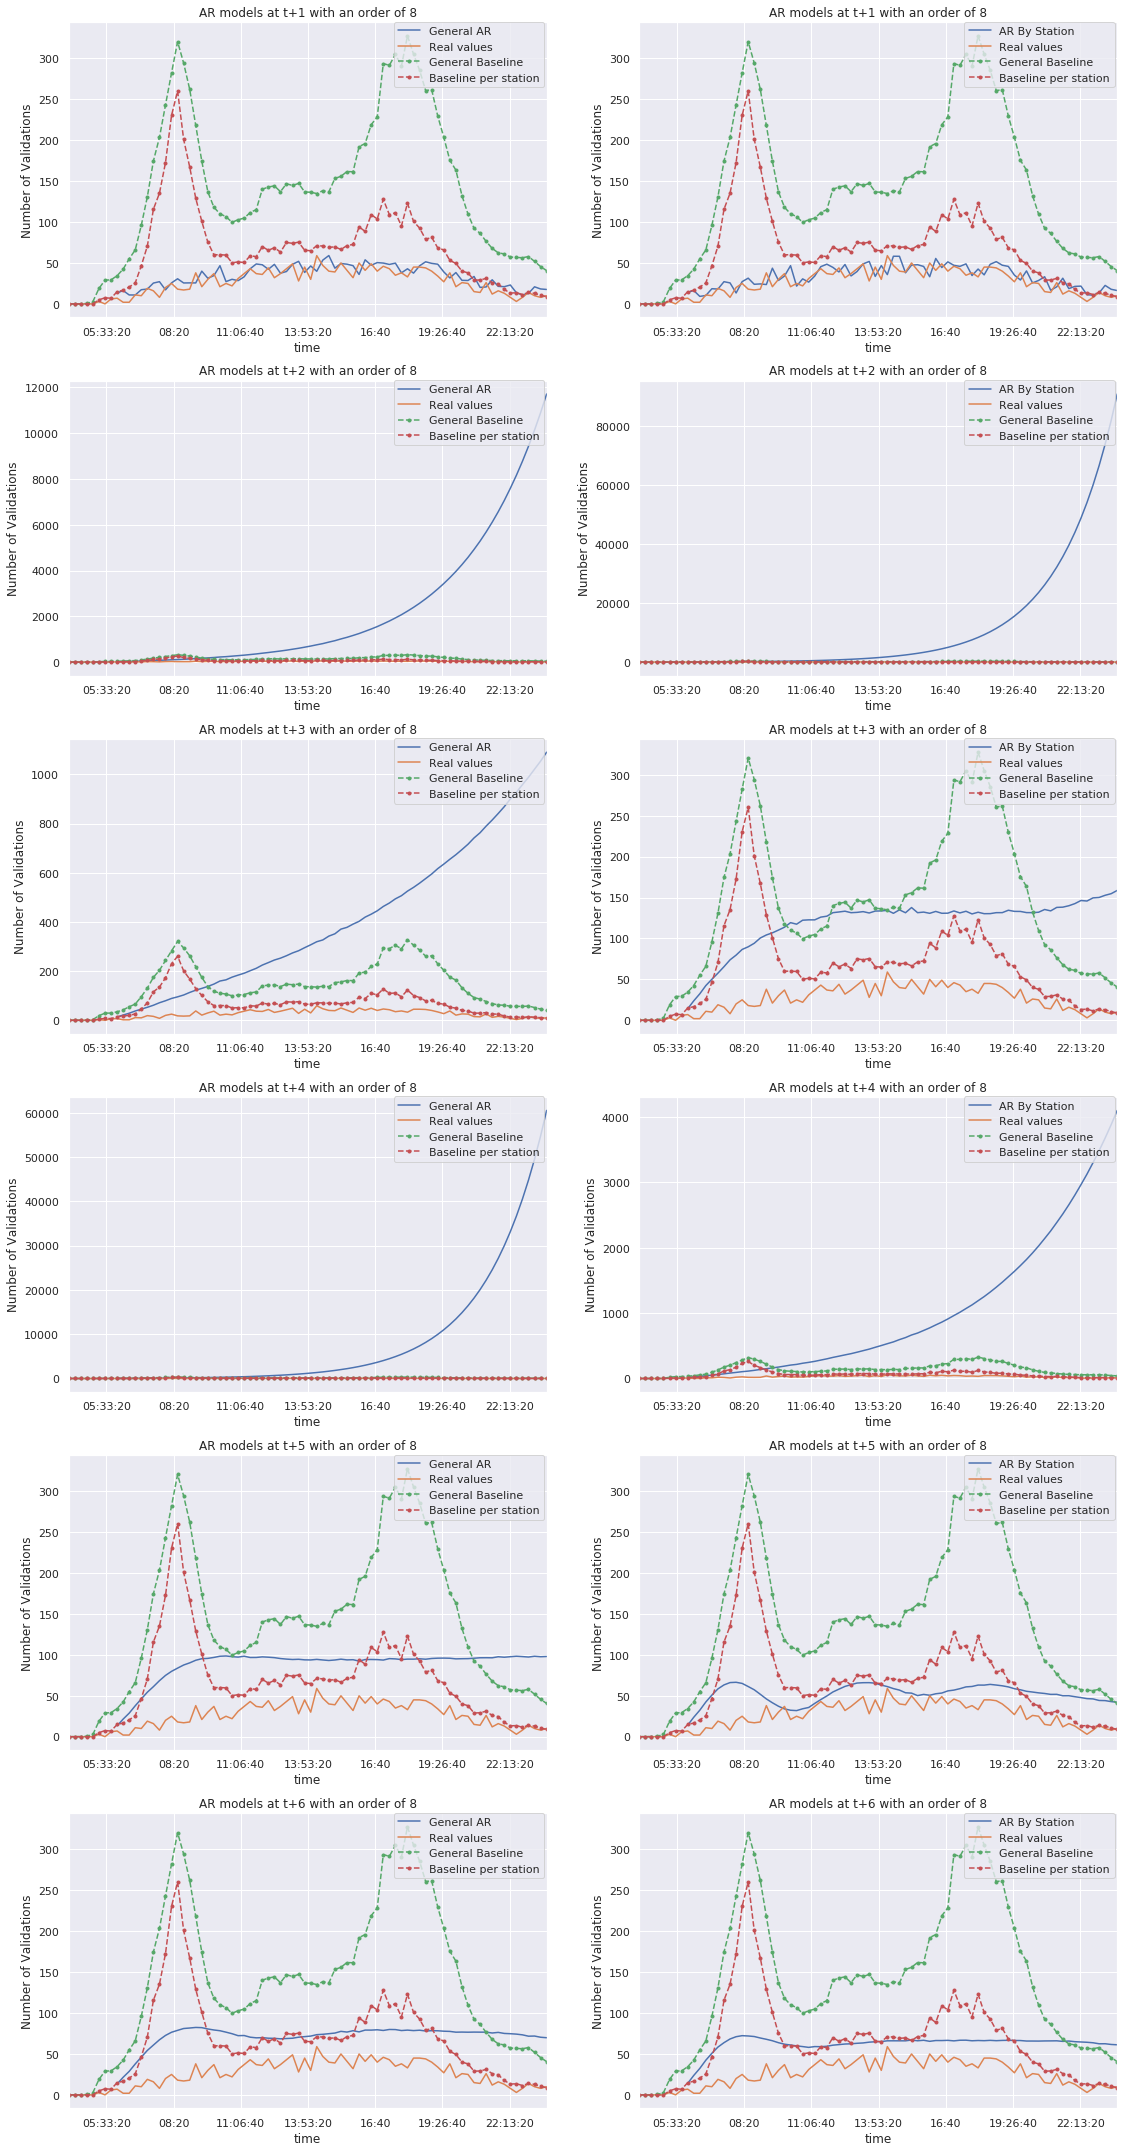

In [105]:
j, s = 0, 5
plot_bispecific(X_test, baseline_preds, ar_preds, ar_preds_s, order, limit_t, j, s)

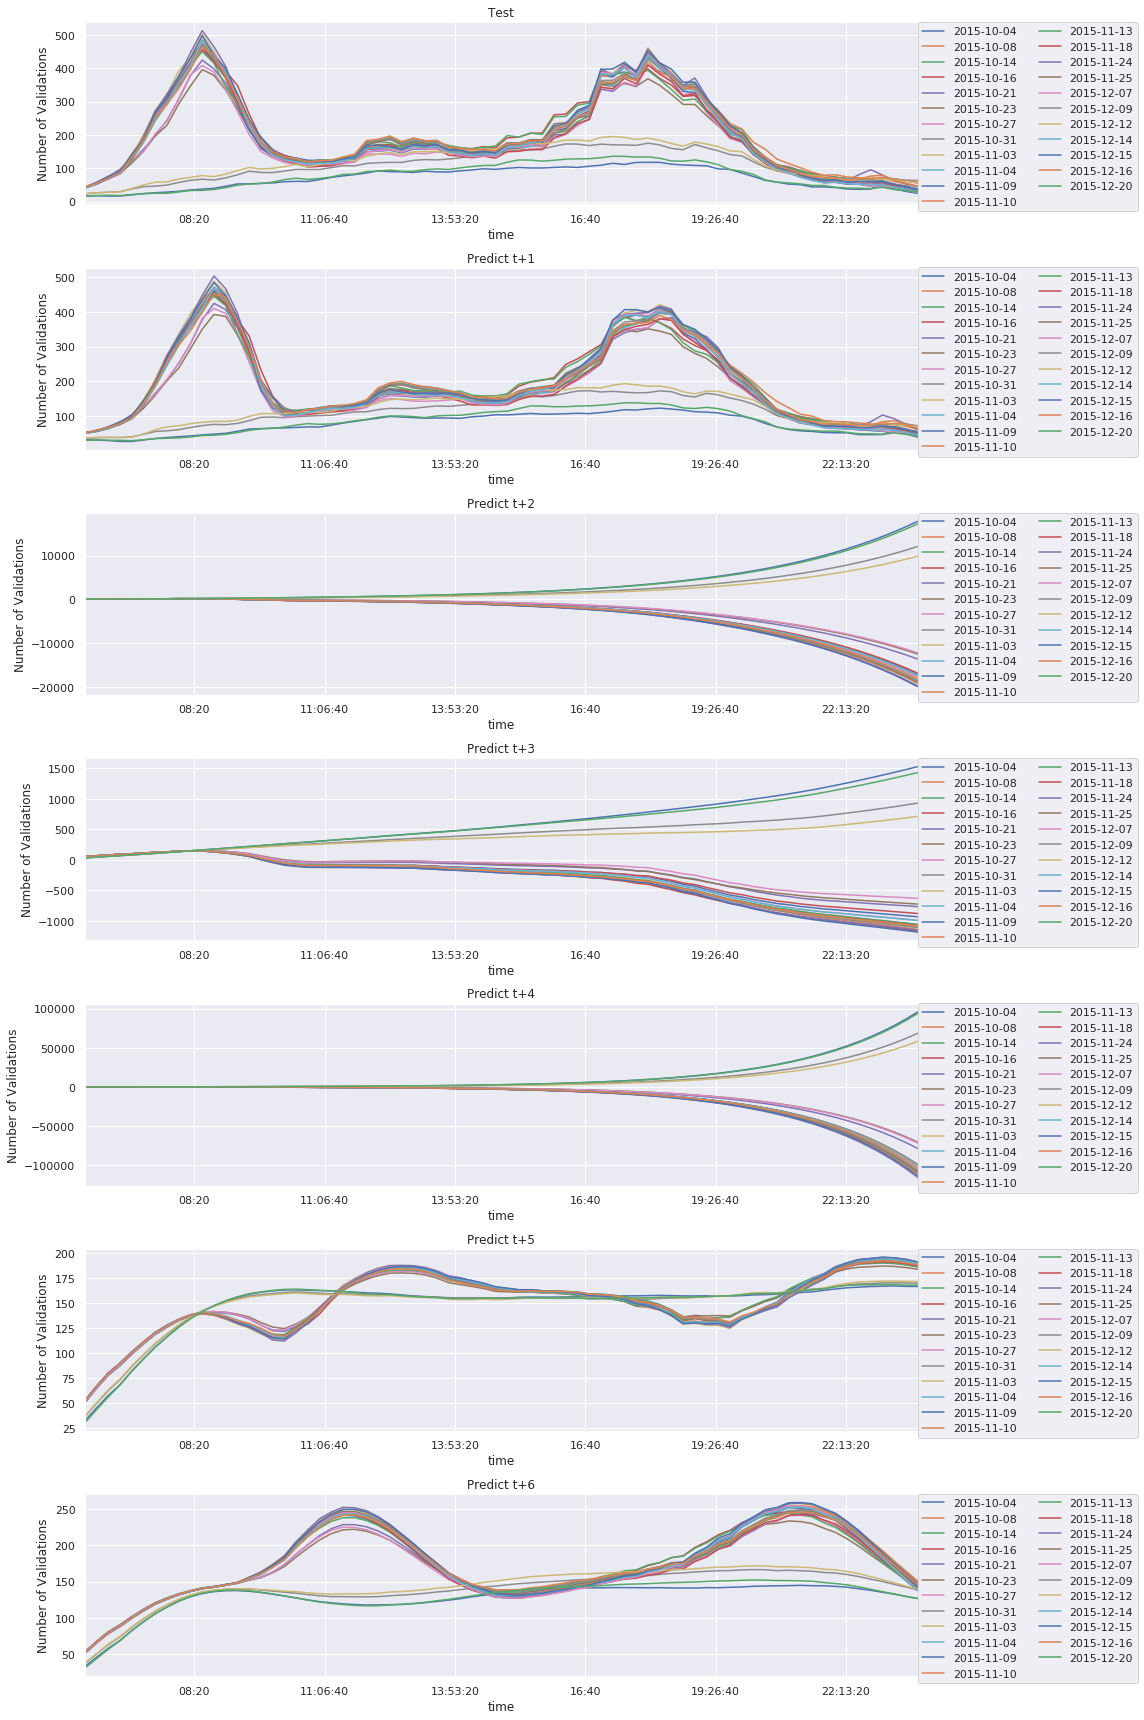

In [106]:
plot_qualitative_analysis(ar_preds, X_test, limit_t, order, subway_stations, del_hours)

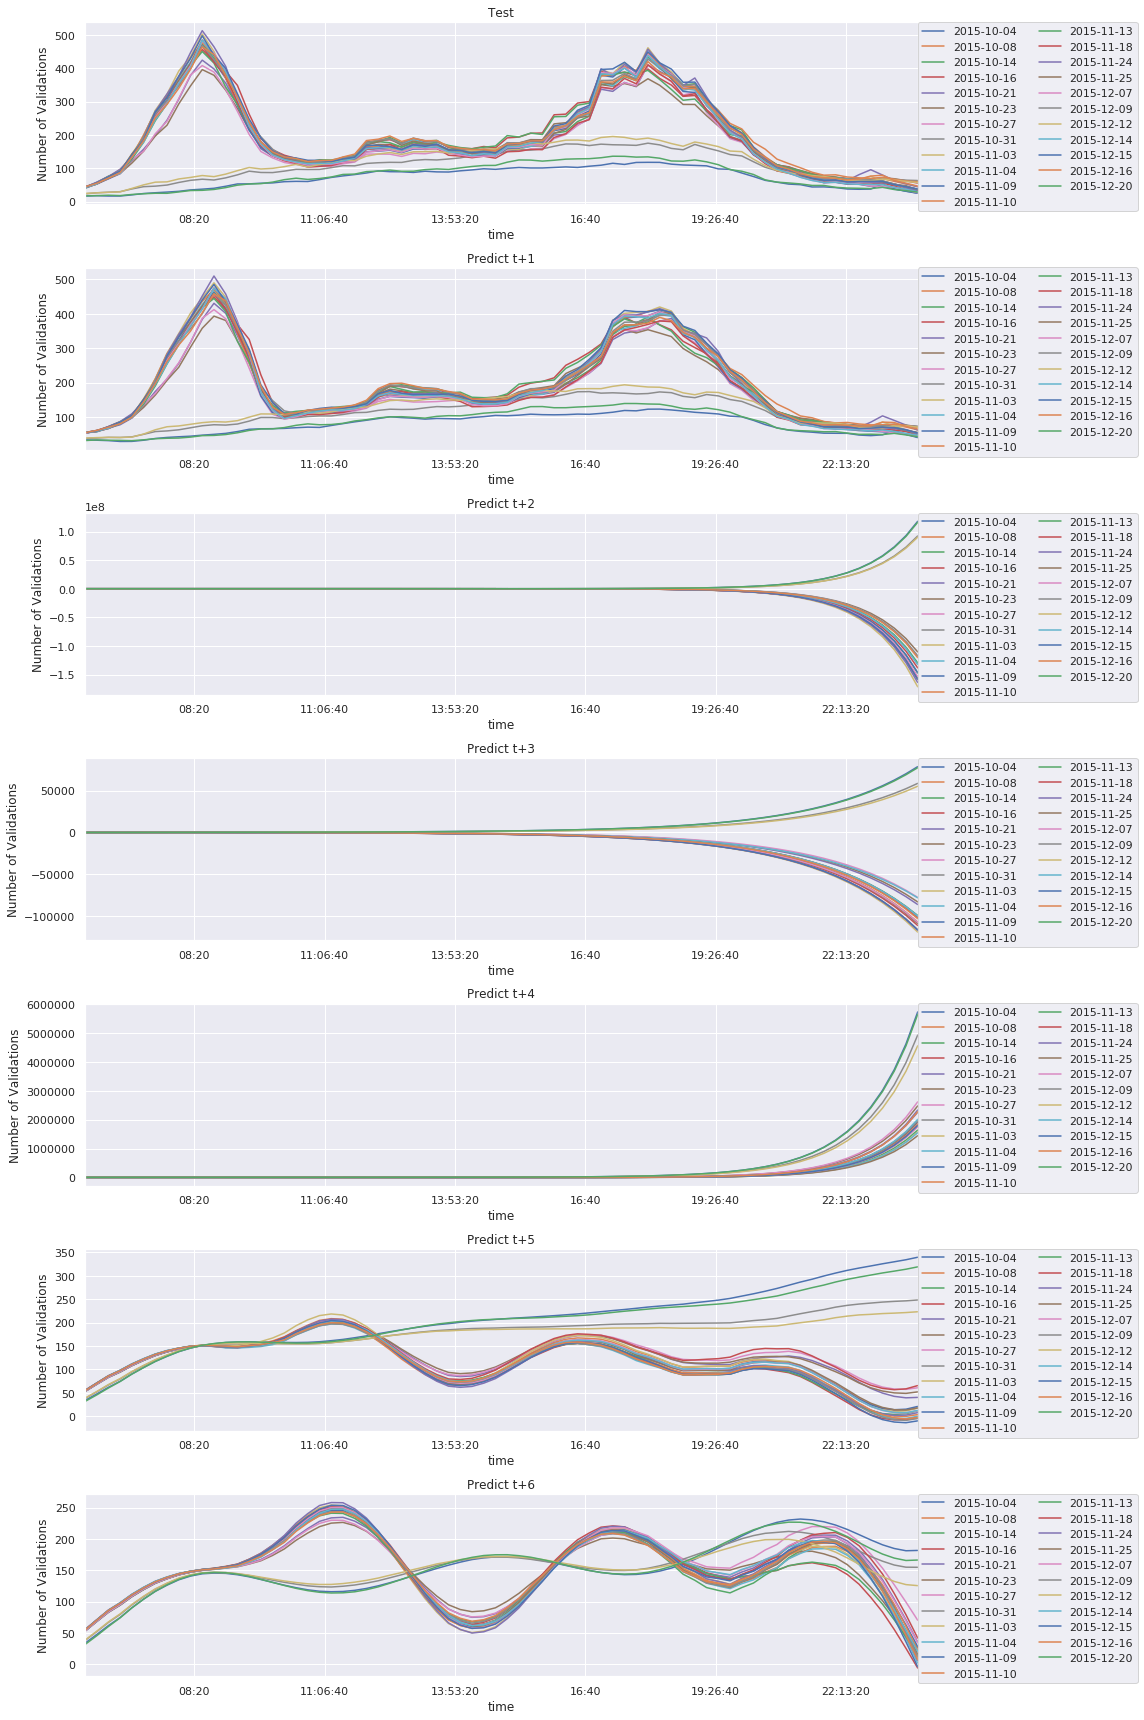

In [107]:
plot_qualitative_analysis(ar_preds_s, X_test, limit_t, order, subway_stations, del_hours)

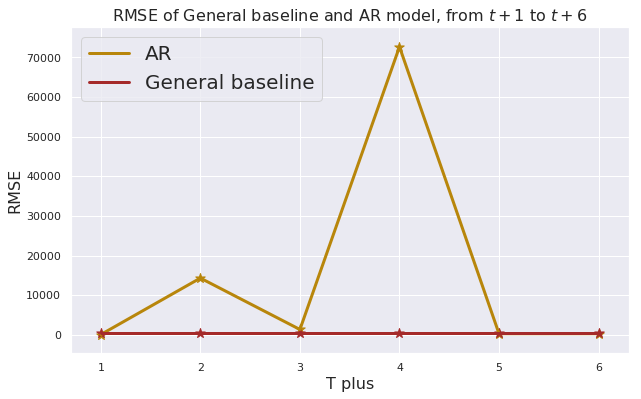

In [108]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.set_prop_cycle(color=['darkgoldenrod', 'brown'])
x = range(1, limit_t+1)
baseline_score = df_baseline_scores.loc['RMSE', 'None'].repeat(limit_t).reshape(-1, limit_t).T
model_score = np.array(ar_scores).T[1]

ax = plt.plot(x, model_score, linewidth=3, label="AR")
ax = plt.scatter(x, model_score, marker='*', s=100)
ax = plt.plot(x, baseline_score, linewidth=3, label="General baseline")
ax = plt.scatter(x, baseline_score, marker='*', s=100)

plt.legend(prop={'size': 20})
plt.title("RMSE of General baseline and AR model, from $t+1$ to $t+{}$".format(limit_t), fontsize=16)
plt.xlabel("T plus", fontsize=16); plt.ylabel("RMSE", fontsize=16);

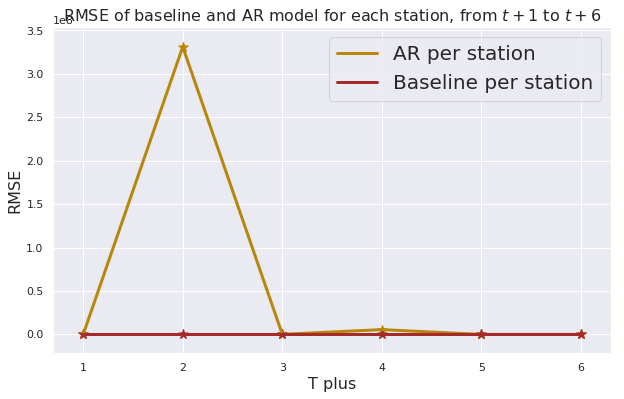

In [109]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.set_prop_cycle(color=['darkgoldenrod', 'brown'])
x = range(1, limit_t+1)
baseline_score = df_baseline_scores.loc['RMSE', 's'].repeat(limit_t).reshape(-1, limit_t).T
model_score = np.array(ar_scores_s).T[1]

ax = plt.plot(x, model_score, linewidth=3, label="AR per station")
ax = plt.scatter(x, model_score, marker='*', s=100)
ax = plt.plot(x, baseline_score, linewidth=3, label="Baseline per station")
ax = plt.scatter(x, baseline_score, marker='*', s=100)

plt.legend(prop={'size': 20})
plt.title("RMSE of baseline and AR model for each station, from $t+1$ to $t+{}$".format(limit_t), fontsize=16)
plt.xlabel("T plus", fontsize=16); plt.ylabel("RMSE", fontsize=16);

#### Compute and Compare 

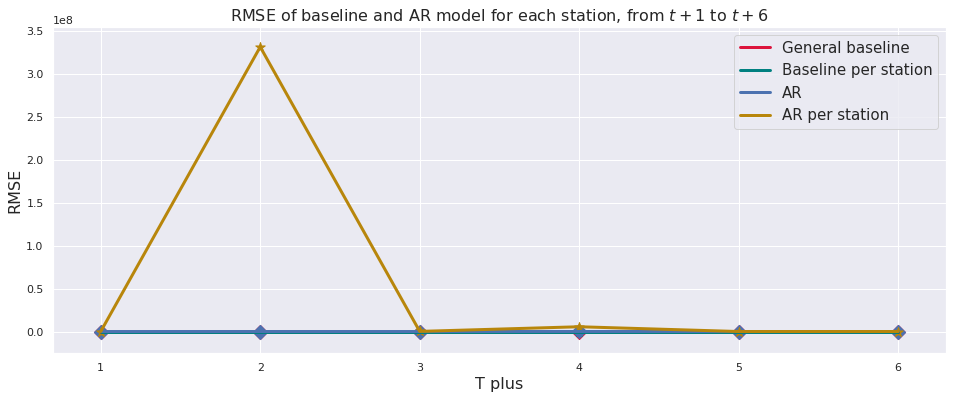

In [110]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.set_prop_cycle(color=['crimson', 'teal', 'b', 'darkgoldenrod'])
x = range(1, limit_t+1)
baseline_scores = df_baseline_scores.loc['RMSE'].values.repeat(limit_t).reshape(-1, limit_t).T
model_scores = np.vstack((np.array(ar_scores).T[1], np.array(ar_scores_s).T[1])).T
baselineObjects = plt.plot(x, baseline_scores, linewidth=3)
labels = ["General baseline", "Baseline per station", "AR", "AR per station"]
arlineObjects = plt.plot(x, model_scores, linewidth=3)

# ['D', '*', '|', 'X']
# labels = ["Full baseline", "Baseline per station", "Baseline per day",
#                    "Baseline per station and day", "Full AR", "AR per station"]
for i, m in zip(range(4), ['D', '*']):
    ax = plt.scatter(x, baseline_scores[:, i], marker=m, s=100)

for i, m in zip(range(2), ['D', '*']):
    ax = plt.scatter(x, model_scores[:, i], marker=m, s=100)
    
plt.legend(baselineObjects+arlineObjects, labels, prop={'size': 15})
plt.title("RMSE of baseline and AR model for each station, from $t+1$ to $t+{}$".format(limit_t), fontsize=16)
plt.xlabel("T plus", fontsize=16); plt.ylabel("RMSE", fontsize=16);

### AR + Baseline

In [111]:
def baseline_sub(X, baseline):
    
    return X.apply(lambda x: x - baseline.iloc[0], axis=(1, 2))
    
def baseline_add(X, baseline):
    
    return X.apply(lambda x: x + baseline.iloc[0], axis=(1, 2))
    

In [112]:
order, limit_t = 8, 6

In [113]:
# Minus Baseline per station
Xb_train = baseline_sub(X_train, baseline_preds[1])
Xb_test = baseline_sub(X_test, baseline_preds[1])

# Minus Baseline per station
Xb_train_s = baseline_sub(X_train, baseline_preds[1])
Xb_test_s = baseline_sub(X_test, baseline_preds[1])

In [114]:
Xb_min_max_s = Xb_train_s.apply(lambda x: (x.min().min(), x.max().max()), axis=(0, 2))

In [115]:
Xbn_train_s = Xb_train_s.apply(lambda x: a + ((x - x.min().min()) * (b - a)) / (x.max().max() - x.min().min()), 
                               axis=(0, 2)).transpose(2, 0, 1)
# Normalize Xb_test
Xbn_test_s = pd.Panel(np.array(list(map(lambda station_id: normalize(
    Xb_test_s, Xb_min_max_s, station_id, a=a, b=b), 
                                        Xb_test_s.transpose(1, 0, 2)))).transpose(2, 0, 1),
                      items=list(Xb_test_s.items),
                      major_axis=subway_stations,
                      minor_axis=generate_times("15min")[(del_hours * 4):])

# Denormalize Xb_test
Xbdn_test_s = pd.Panel(np.array(list(map(lambda station_id: denormalize(
    Xbn_test_s, Xb_min_max_s, station_id, a=a, b=b), 
                                        Xb_test_s.transpose(1, 0, 2)))).transpose(2, 0, 1),
                      items=list(Xb_test_s.items),
                      major_axis=subway_stations,
                      minor_axis=generate_times("15min")[(del_hours * 4):])

In [116]:
%%time
arb_preds, arb_scores = ar_plot_results(None, order, limit_t, X_train=Xbn_train_s, 
                                      X_test=Xbn_test_s, X_min_max=Xb_min_max_s, a=a, b=b)
for t in range(limit_t):
    arb_preds[t] = baseline_add(arb_preds[t], baseline_preds[1])

Fitting...


Predicting...


CPU times: user 42.3 s, sys: 4.44 s, total: 46.8 s
Wall time: 41.3 s


In [117]:
%%time
arb_preds_s, arb_scores_s = ar_plot_results("s", order, limit_t,  
                                          X_train=Xbn_train_s, 
                                          X_test=Xbn_test_s,
                                          X_min_max=Xb_min_max_s, a=a, b=b)
for t in range(limit_t):
    arb_preds_s[t] = baseline_add(arb_preds_s[t], baseline_preds[1]) 

Fitting...


Predicting...


CPU times: user 1min 47s, sys: 1min 10s, total: 2min 57s
Wall time: 1min 19s


In [118]:
baseline_preds[0].items

Index([2015-10-04, 2015-10-08, 2015-10-14, 2015-10-16, 2015-10-21, 2015-10-23,
       2015-10-27, 2015-10-31, 2015-11-03, 2015-11-04, 2015-11-09, 2015-11-10,
       2015-11-13, 2015-11-18, 2015-11-24, 2015-11-25, 2015-12-07, 2015-12-09,
       2015-12-12, 2015-12-14, 2015-12-15, 2015-12-16, 2015-12-20],
      dtype='object')

In [119]:
arb_preds[0].items

Index([2015-10-04, 2015-10-08, 2015-10-14, 2015-10-16, 2015-10-21, 2015-10-23,
       2015-10-27, 2015-10-31, 2015-11-03, 2015-11-04, 2015-11-09, 2015-11-10,
       2015-11-13, 2015-11-18, 2015-11-24, 2015-11-25, 2015-12-07, 2015-12-09,
       2015-12-12, 2015-12-14, 2015-12-15, 2015-12-16, 2015-12-20],
      dtype='object')

In [120]:
X_test.items

Index([2015-10-04, 2015-10-08, 2015-10-14, 2015-10-16, 2015-10-21, 2015-10-23,
       2015-10-27, 2015-10-31, 2015-11-03, 2015-11-04, 2015-11-09, 2015-11-10,
       2015-11-13, 2015-11-18, 2015-11-24, 2015-11-25, 2015-12-07, 2015-12-09,
       2015-12-12, 2015-12-14, 2015-12-15, 2015-12-16, 2015-12-20],
      dtype='object')

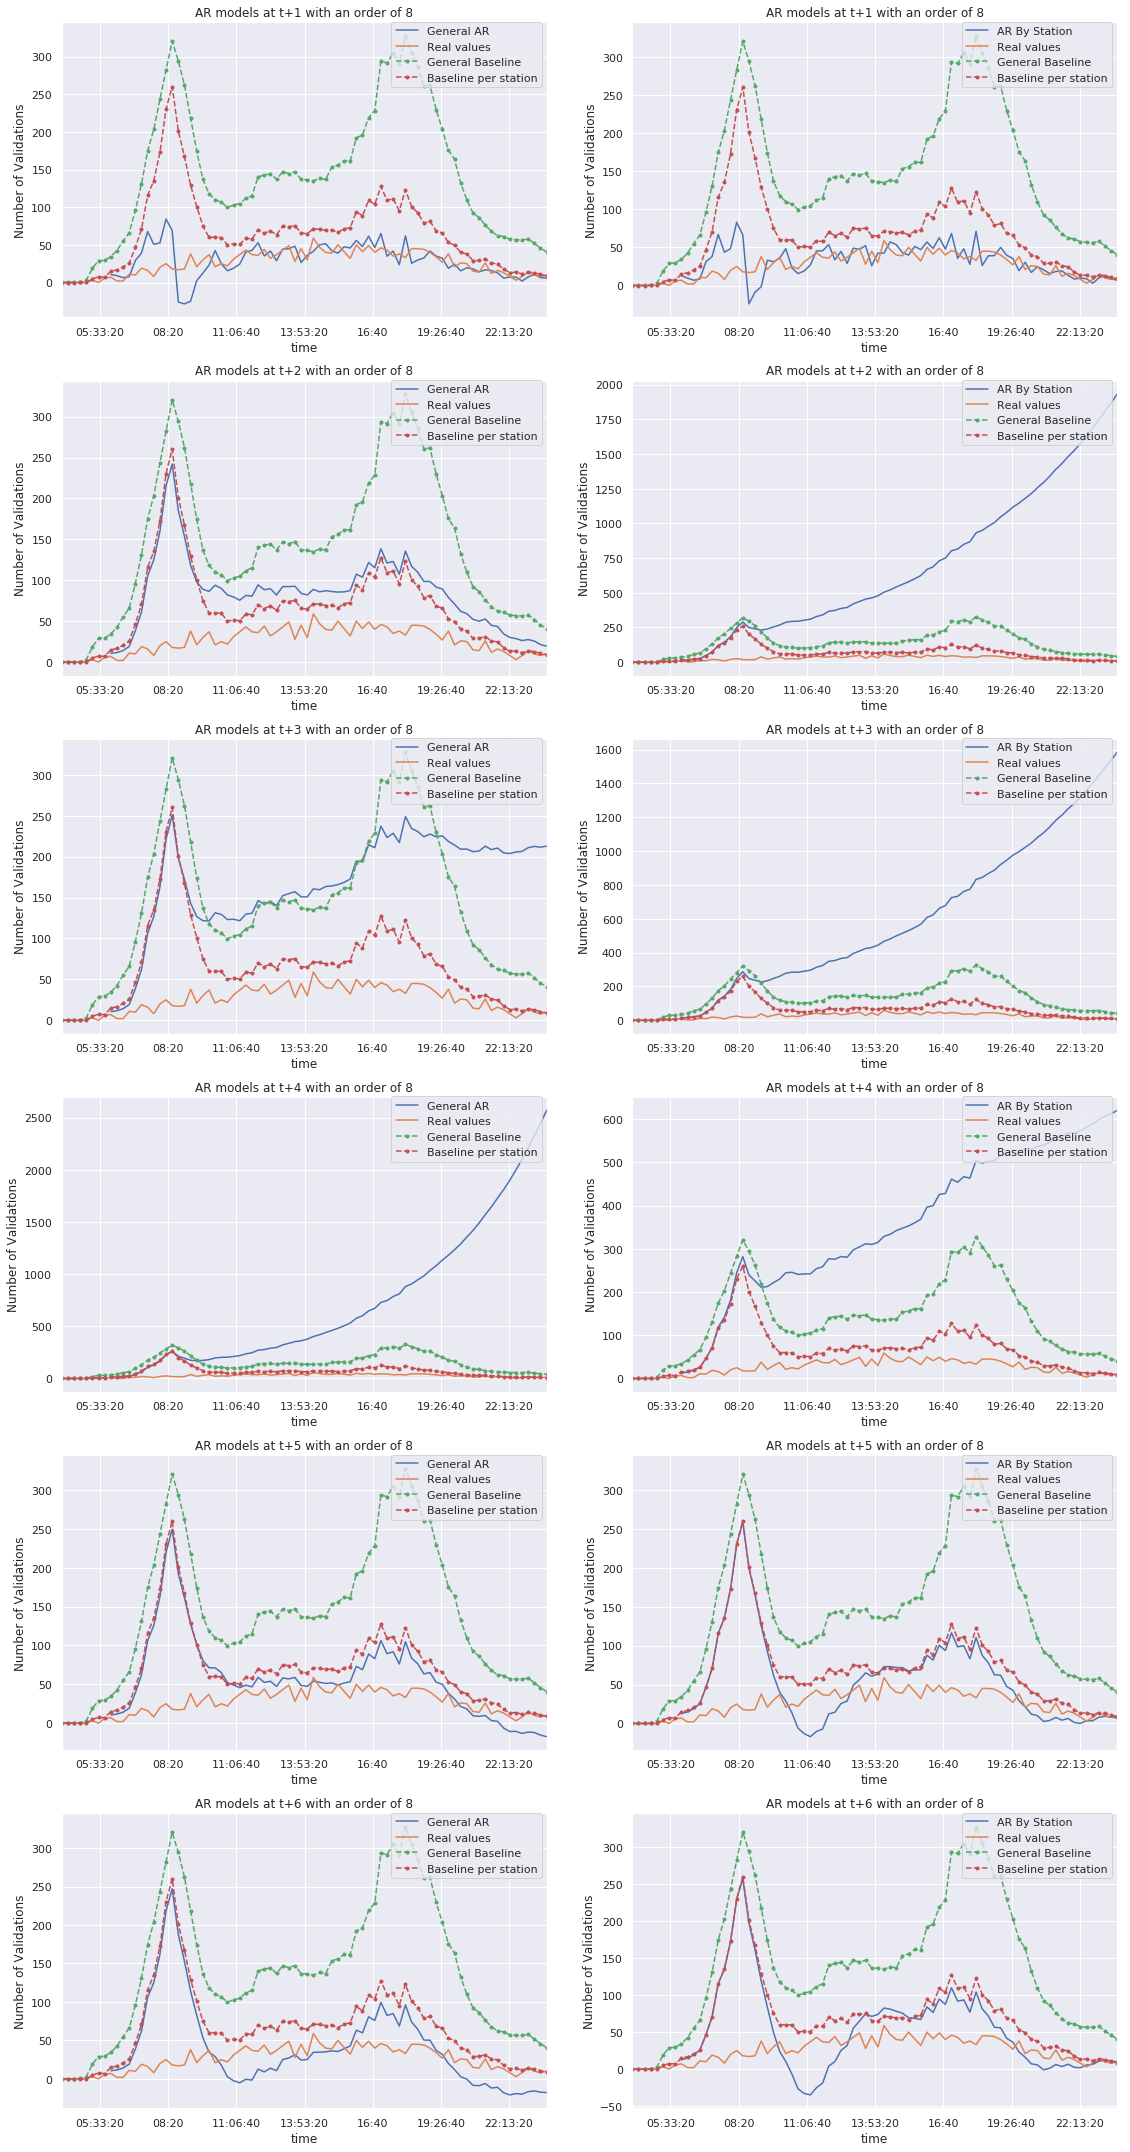

In [121]:
plot_bispecific(X_test, baseline_preds, arb_preds, arb_preds_s, order, limit_t, j, s)

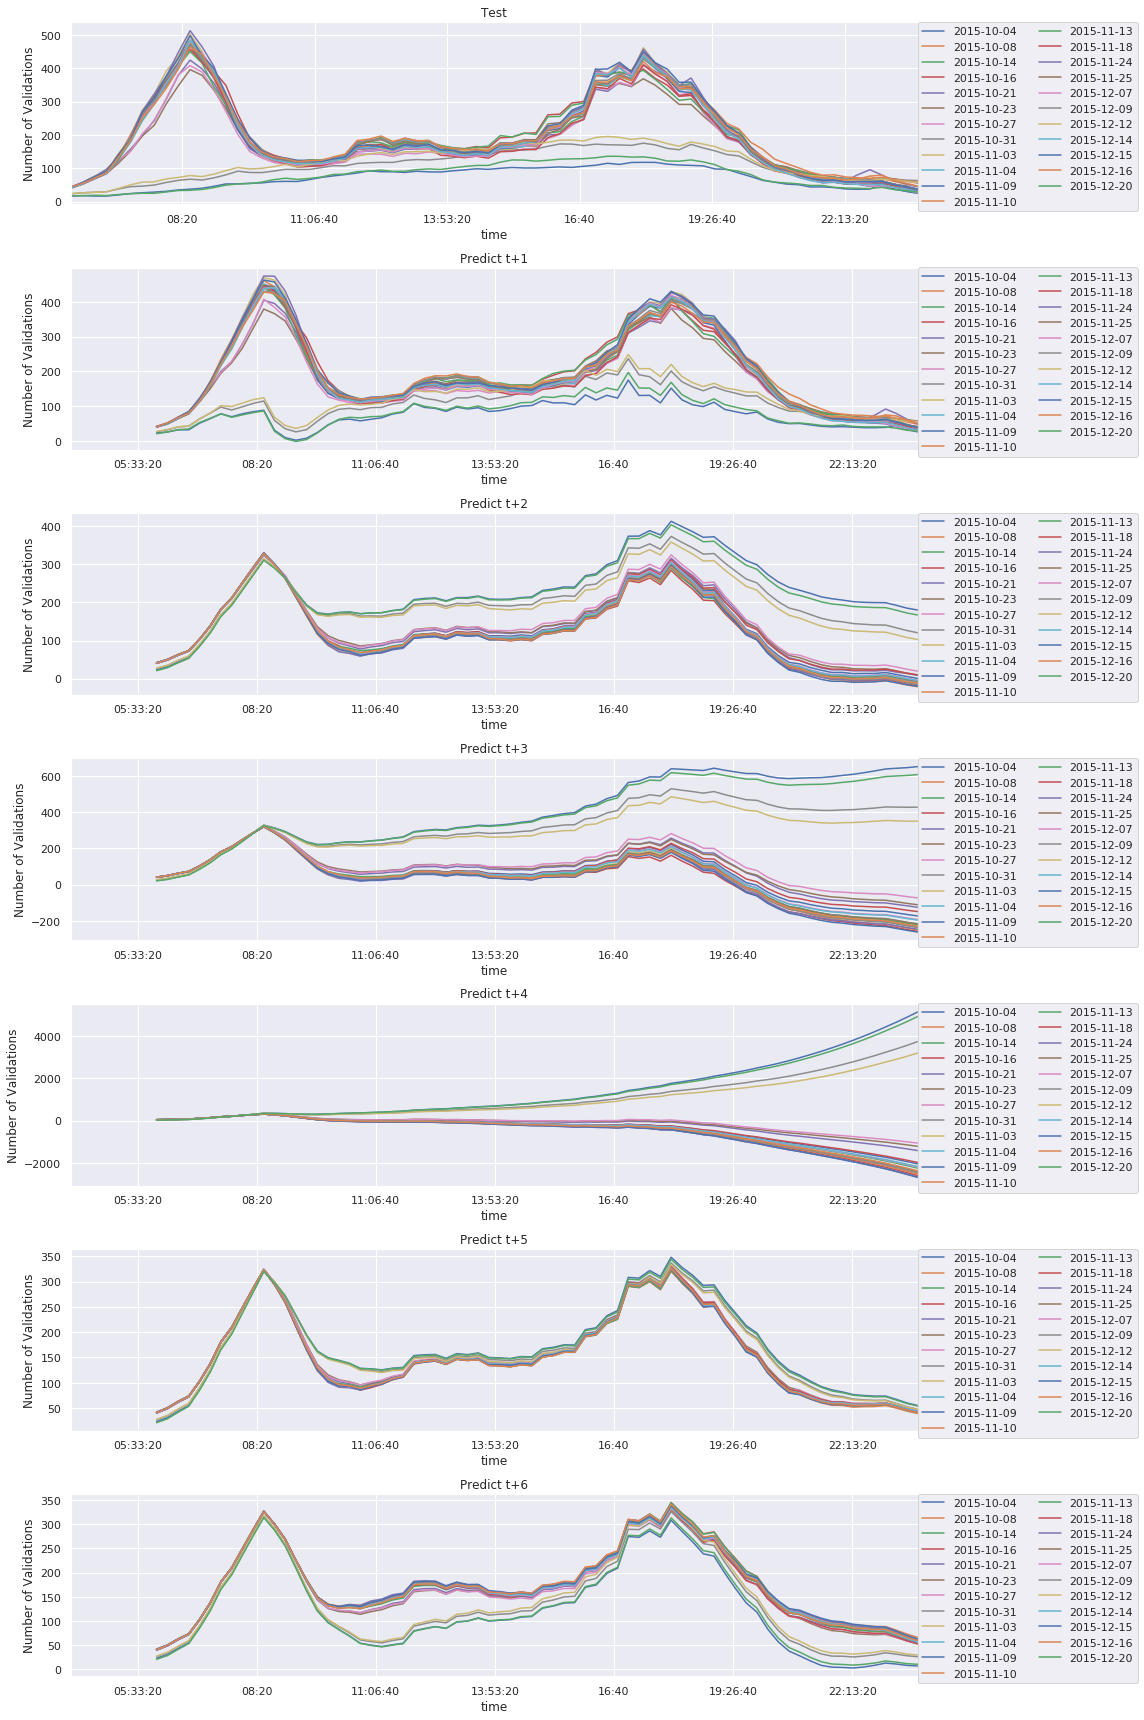

In [122]:
plot_qualitative_analysis(arb_preds, X_test, limit_t, order, subway_stations, del_hours)

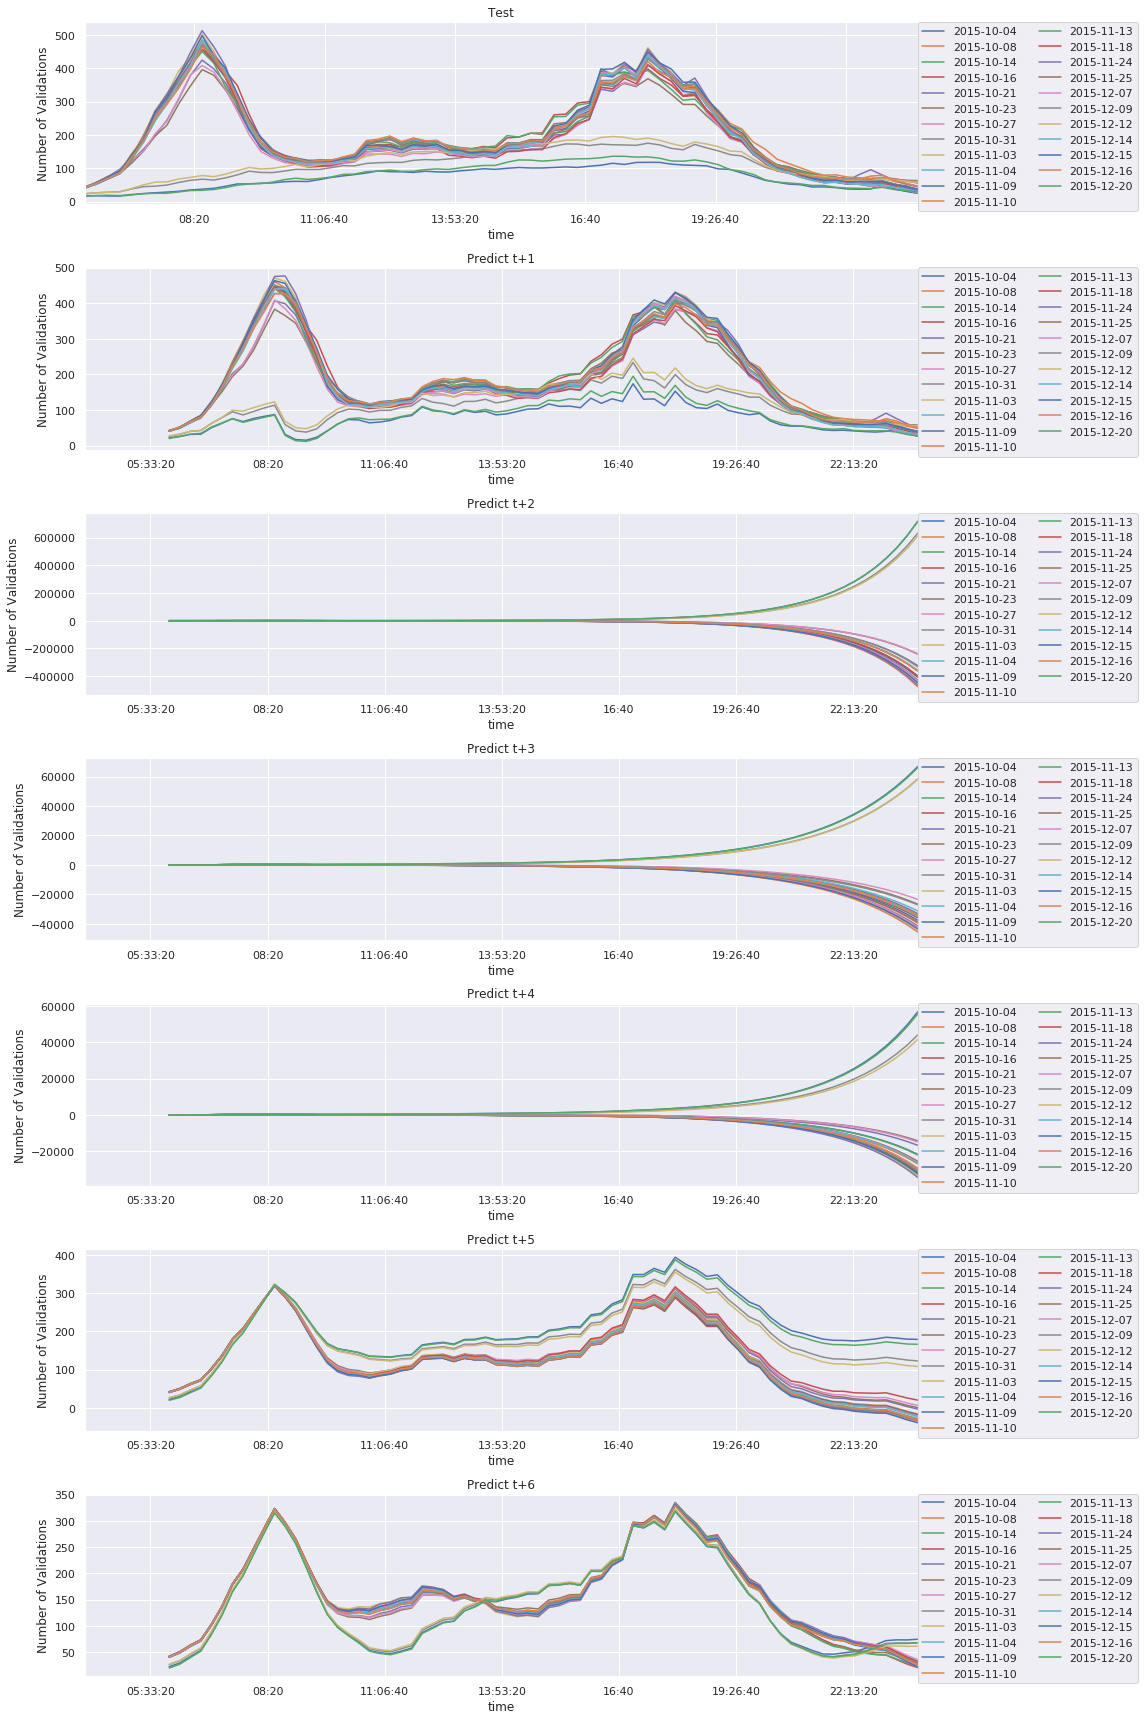

In [123]:
plot_qualitative_analysis(arb_preds_s, X_test, limit_t, order, subway_stations, del_hours)

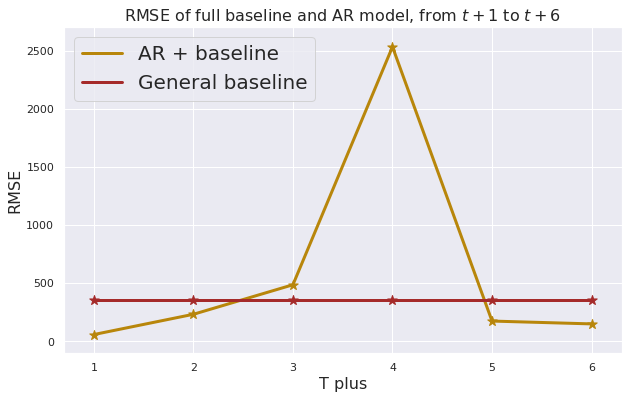

In [124]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.set_prop_cycle(color=['darkgoldenrod', 'brown'])
x = range(1, limit_t+1)
baseline_score = df_baseline_scores.loc['RMSE', 'None'].repeat(limit_t).reshape(-1, limit_t).T
model_score = np.array(arb_scores).T[1]

ax = plt.plot(x, model_score, linewidth=3, label="AR + baseline")
ax = plt.scatter(x, model_score, marker='*', s=100)
ax = plt.plot(x, baseline_score, linewidth=3, label="General baseline")
ax = plt.scatter(x, baseline_score, marker='*', s=100)

plt.legend(prop={'size': 20})
plt.title("RMSE of full baseline and AR model, from $t+1$ to $t+{}$".format(limit_t), fontsize=16)
plt.xlabel("T plus", fontsize=16); plt.ylabel("RMSE", fontsize=16);

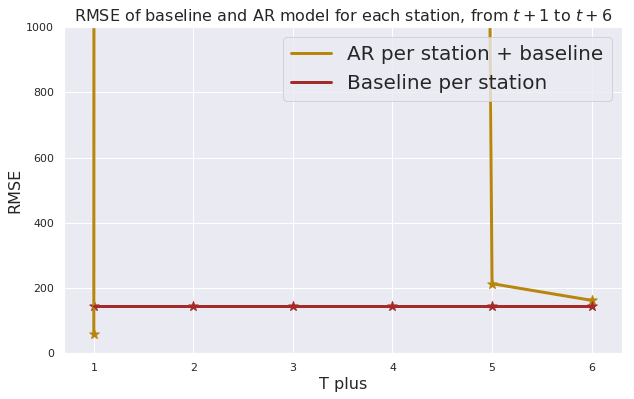

In [125]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.set_prop_cycle(color=['darkgoldenrod', 'brown'])
x = range(1, limit_t+1)
baseline_score = df_baseline_scores.loc['RMSE', 's'].repeat(limit_t).reshape(-1, limit_t).T
model_score = np.array(arb_scores_s).T[1]

ax = plt.plot(x, model_score, linewidth=3, label="AR per station + baseline")
ax = plt.scatter(x, model_score, marker='*', s=100)
ax = plt.plot(x, baseline_score, linewidth=3, label="Baseline per station")
ax = plt.scatter(x, baseline_score, marker='*', s=100)

plt.ylim((0, 1000))
plt.legend(prop={'size': 20})
plt.title("RMSE of baseline and AR model for each station, from $t+1$ to $t+{}$".format(limit_t), fontsize=16)
plt.xlabel("T plus", fontsize=16); plt.ylabel("RMSE", fontsize=16);

#### Compute and Compare 

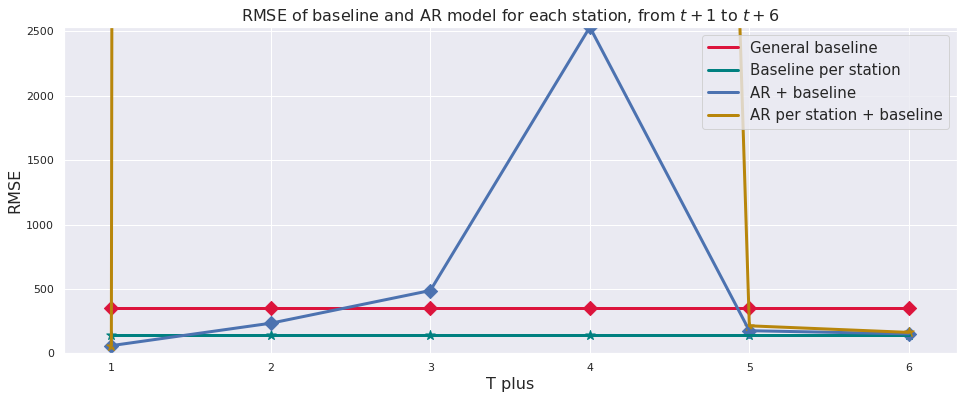

In [126]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.set_prop_cycle(color=['crimson', 'teal', 'b', 'darkgoldenrod'])

x = range(1, limit_t+1)
baseline_scores = df_baseline_scores.loc['RMSE'].values.repeat(limit_t).reshape(-1, limit_t).T
model_scores = np.vstack((np.array(arb_scores).T[1], np.array(arb_scores_s).T[1])).T

baselineObjects = plt.plot(x, baseline_scores, linewidth=3)
labels = ["General baseline", "Baseline per station", "AR + baseline", "AR per station + baseline"]

arlineObjects = plt.plot(x, model_scores, linewidth=3)

for i, m in zip(range(4), ['D', '*']):
    ax = plt.scatter(x, baseline_scores[:, i], marker=m, s=100)

for i, m in zip(range(2), ['D', '*']):
    ax = plt.scatter(x, model_scores[:, i], marker=m, s=100)

plt.ylim((0, model_scores[:, 0].max()))
plt.legend(baselineObjects+arlineObjects, labels, prop={'size': 15})
plt.title("RMSE of baseline and AR model for each station, from $t+1$ to $t+{}$".format(limit_t), fontsize=16)
plt.xlabel("T plus", fontsize=16); plt.ylabel("RMSE", fontsize=16);

# Recurrent Neural Networks

In [67]:
import torch.nn as nn

In [68]:
class UnivariateRNN(nn.module):
    pass

AttributeError: module 'torch.nn' has no attribute 'module'

## Brouillon 

In [268]:
ar_preds_s

[<class 'pandas.core.panel.Panel'>
 Dimensions: 23 (items) x 301 (major_axis) x 76 (minor_axis)
 Items axis: 2015-10-15 to 2015-10-17
 Major_axis axis: 198 to 60982
 Minor_axis axis: 05:00:00 to 23:45:00, <class 'pandas.core.panel.Panel'>
 Dimensions: 23 (items) x 301 (major_axis) x 76 (minor_axis)
 Items axis: 2015-10-15 to 2015-10-17
 Major_axis axis: 198 to 60982
 Minor_axis axis: 05:00:00 to 23:45:00, <class 'pandas.core.panel.Panel'>
 Dimensions: 23 (items) x 301 (major_axis) x 76 (minor_axis)
 Items axis: 2015-10-15 to 2015-10-17
 Major_axis axis: 198 to 60982
 Minor_axis axis: 05:00:00 to 23:45:00, <class 'pandas.core.panel.Panel'>
 Dimensions: 23 (items) x 301 (major_axis) x 76 (minor_axis)
 Items axis: 2015-10-15 to 2015-10-17
 Major_axis axis: 198 to 60982
 Minor_axis axis: 05:00:00 to 23:45:00]

In [269]:
arb_preds[0].minor_axis

Index([04:00:00, 04:15:00, 04:30:00, 04:45:00, 05:00:00, 05:15:00, 05:30:00,
       05:45:00, 06:00:00, 06:15:00, 06:30:00, 06:45:00, 07:00:00, 07:15:00,
       07:30:00, 07:45:00, 08:00:00, 08:15:00, 08:30:00, 08:45:00, 09:00:00,
       09:15:00, 09:30:00, 09:45:00, 10:00:00, 10:15:00, 10:30:00, 10:45:00,
       11:00:00, 11:15:00, 11:30:00, 11:45:00, 12:00:00, 12:15:00, 12:30:00,
       12:45:00, 13:00:00, 13:15:00, 13:30:00, 13:45:00, 14:00:00, 14:15:00,
       14:30:00, 14:45:00, 15:00:00, 15:15:00, 15:30:00, 15:45:00, 16:00:00,
       16:15:00, 16:30:00, 16:45:00, 17:00:00, 17:15:00, 17:30:00, 17:45:00,
       18:00:00, 18:15:00, 18:30:00, 18:45:00, 19:00:00, 19:15:00, 19:30:00,
       19:45:00, 20:00:00, 20:15:00, 20:30:00, 20:45:00, 21:00:00, 21:15:00,
       21:30:00, 21:45:00, 22:00:00, 22:15:00, 22:30:00, 22:45:00, 23:00:00,
       23:15:00, 23:30:00, 23:45:00],
      dtype='object')

In [243]:
len(generate_times("15min")[(del_hours * 4) + 4:])

76